In [10]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
sys.path.append('..')
from load_data import load_masks, Dataset, split_train_val_test
from unet import UNet
from config import *

In [3]:
masks, scores = load_masks(verse2019_dir)

Loading masks from /mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/masks_bodies...


  0%|          | 0/120 [00:00<?, ?it/s]

In [4]:
# make train/val split
train_set, val_set, test_set = split_train_val_test(masks, scores, patch_size)

Available cases: 120 
train: 96, val: 12, test: 12
Extracting patches...


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

train: 732, val: 71, test: 70


In [5]:
# initialize data loaders
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [7]:
# load pretrained net
run_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/experiments/shape_prediction/unet_test'
model_path = os.path.join(run_dir, 'best_model_epoch_29_loss_0.05.pt')
print(model_path)

/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/experiments/shape_prediction/unet_test/best_model_epoch_29_loss_0.05.pt


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

UNet(
  (down1): DownBlock(
    (doubleconv): DoubleConv(
      (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownBlock(
    (doubleconv): DoubleConv(
      (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): DownBlock(
    (doubleconv): DoubleConv(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    )
    (maxpool): MaxPool3d(kerne

Loss: 0.025786641985177994


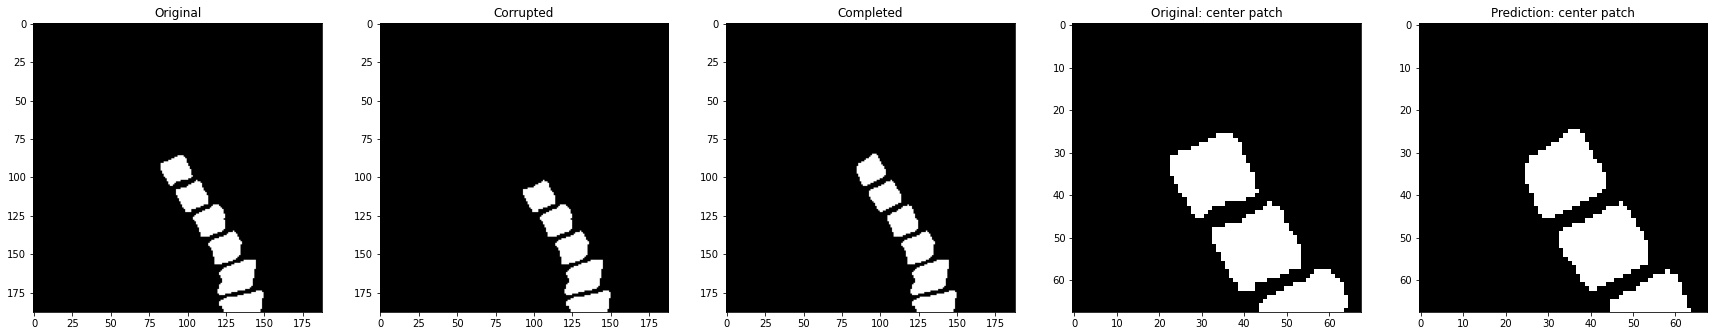

Loss: 0.029661154374480247


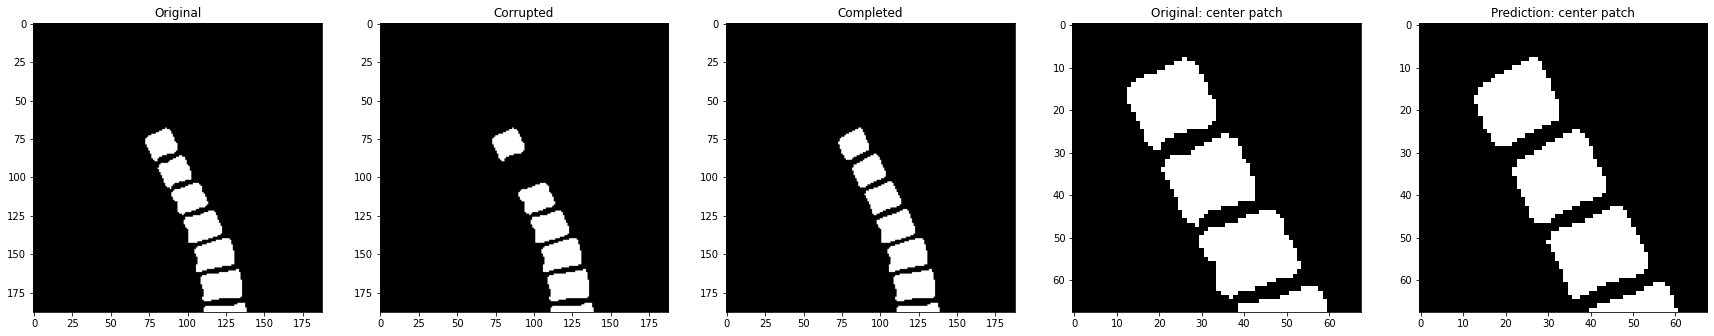

Loss: 0.028067748993635178


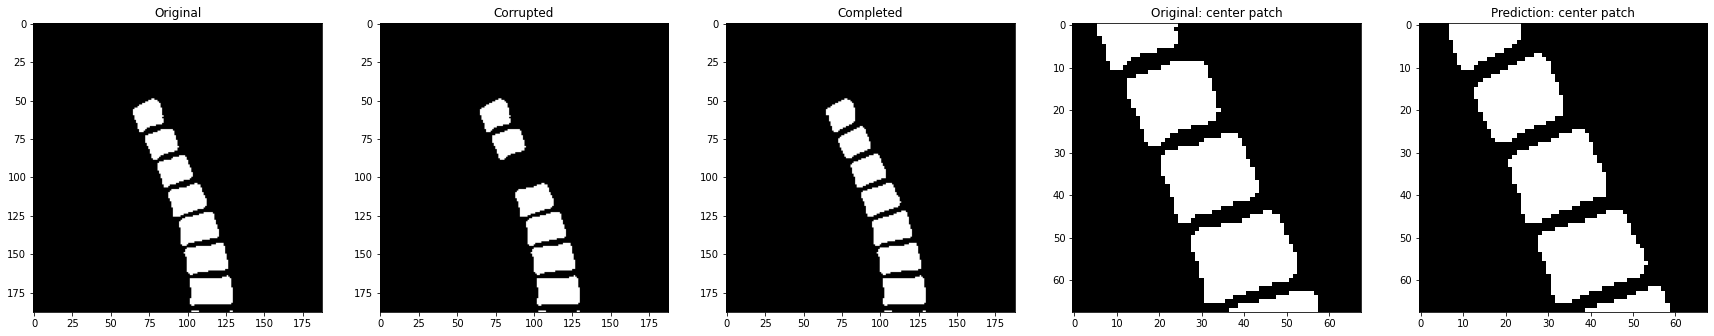

Loss: 0.025355063378810883


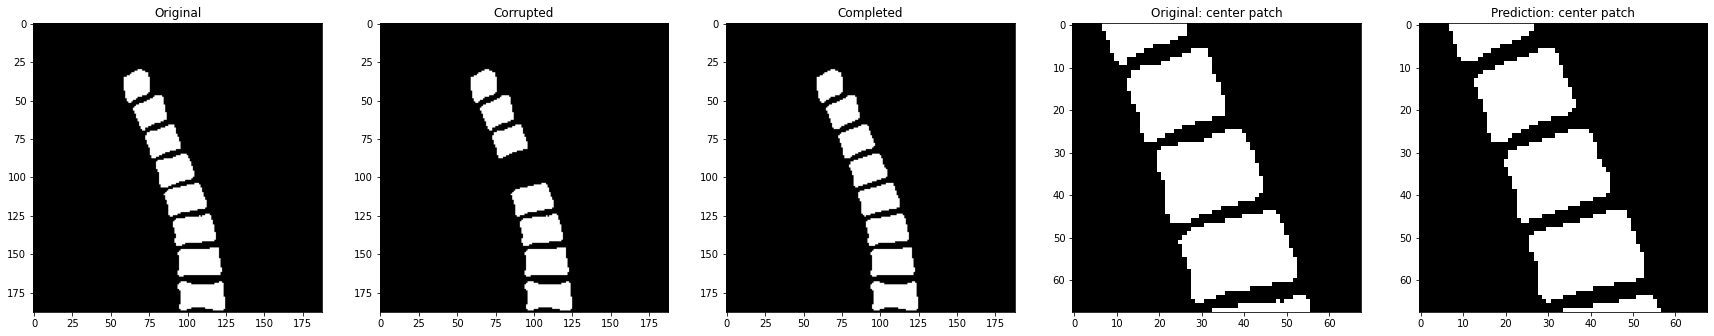

Loss: 0.02551100216805935


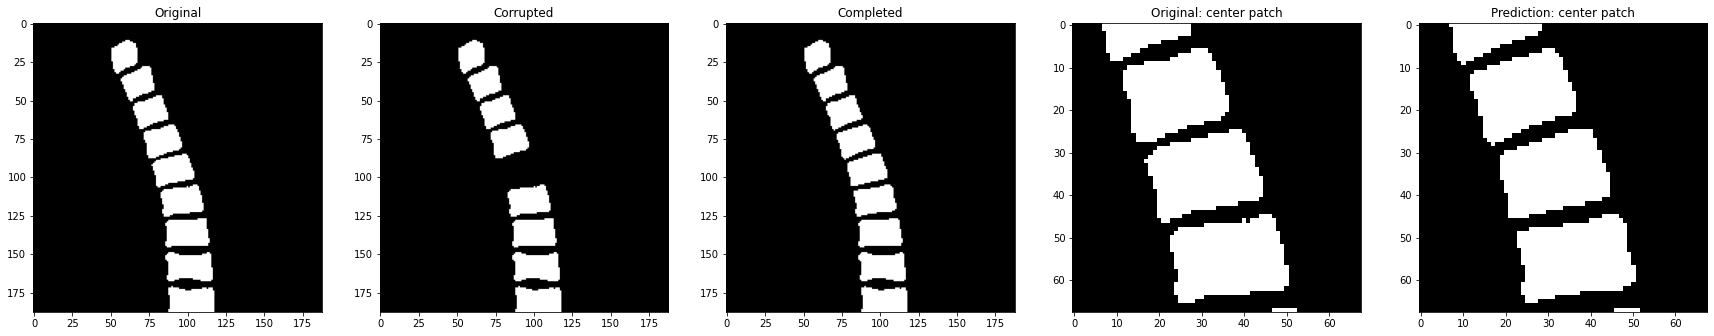

Loss: 0.025587784126400948


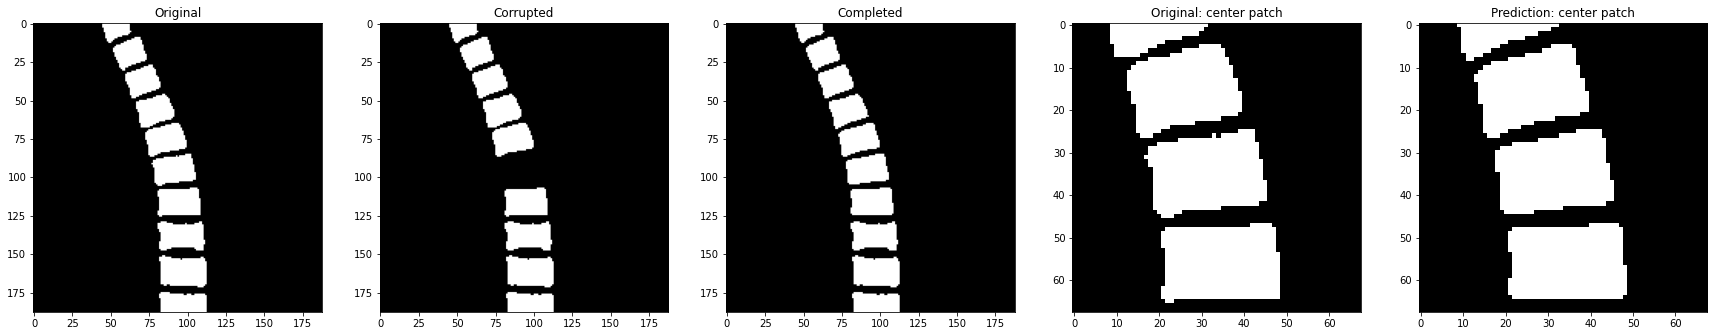

Loss: 0.028865840286016464


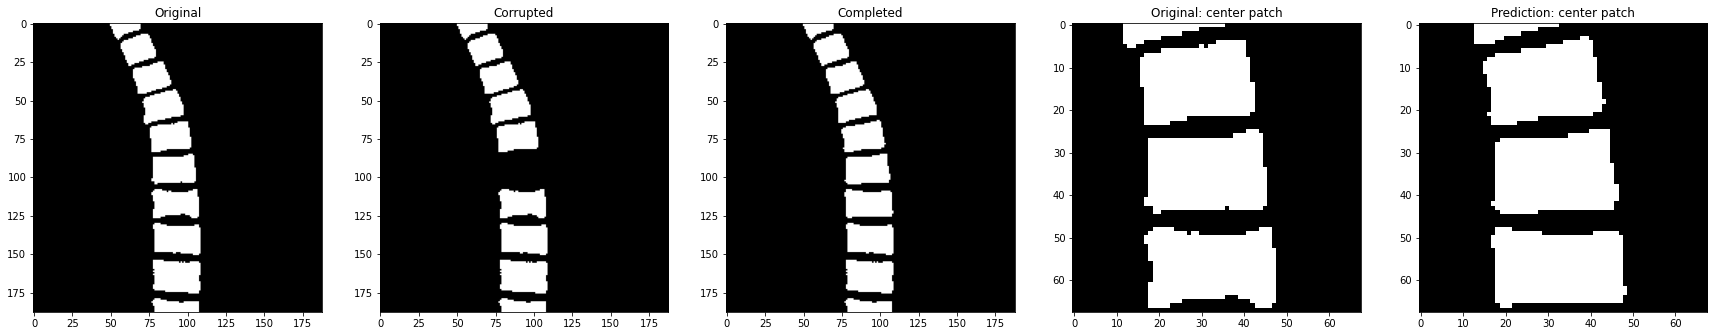

Loss: 0.03164095804095268


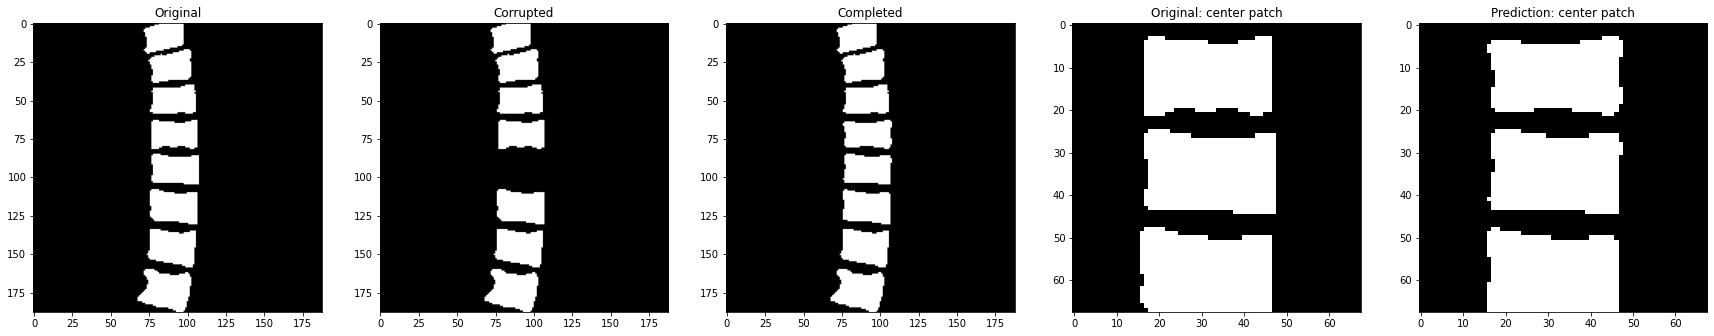

Loss: 0.03313421830534935


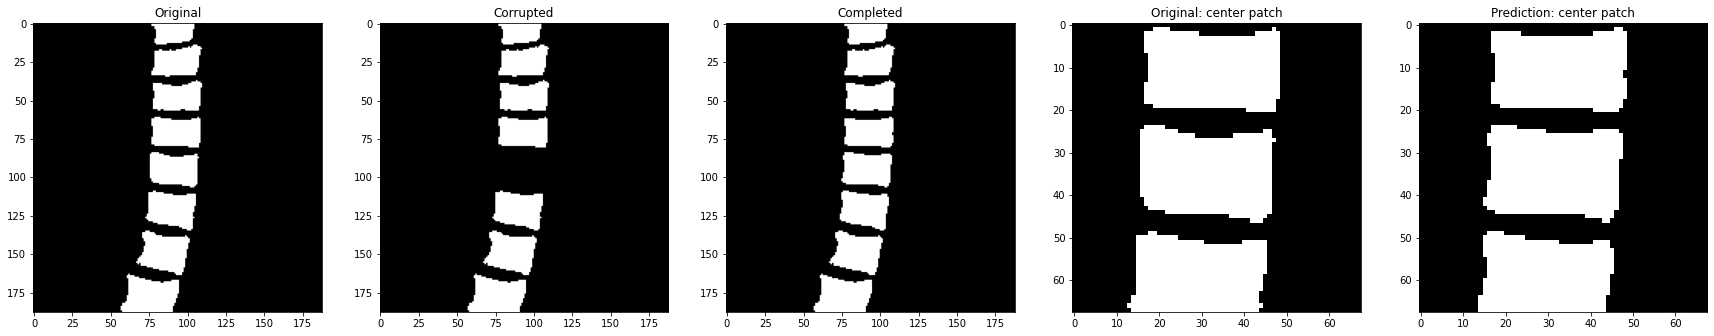

Loss: 0.0440300889313221


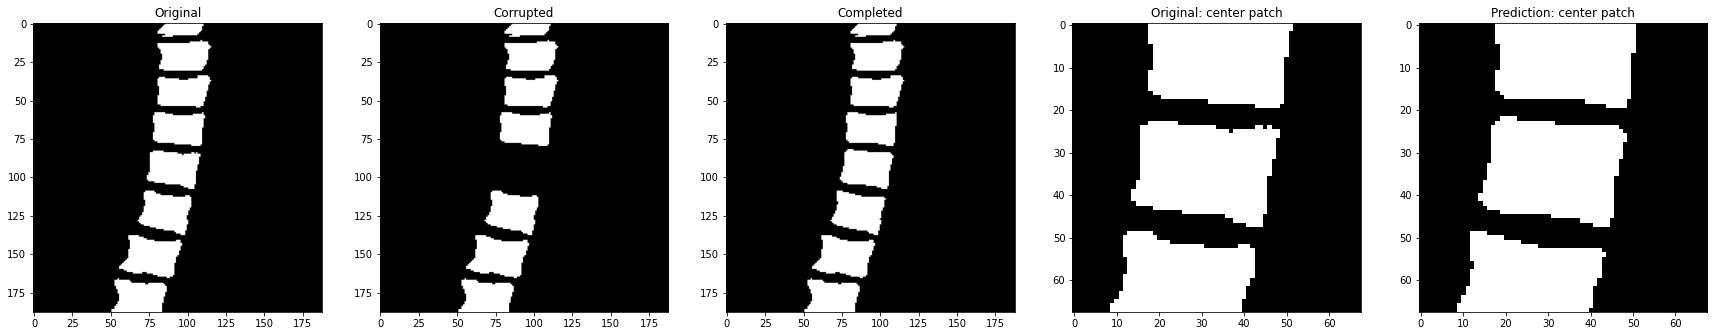

Loss: 0.055008579045534134


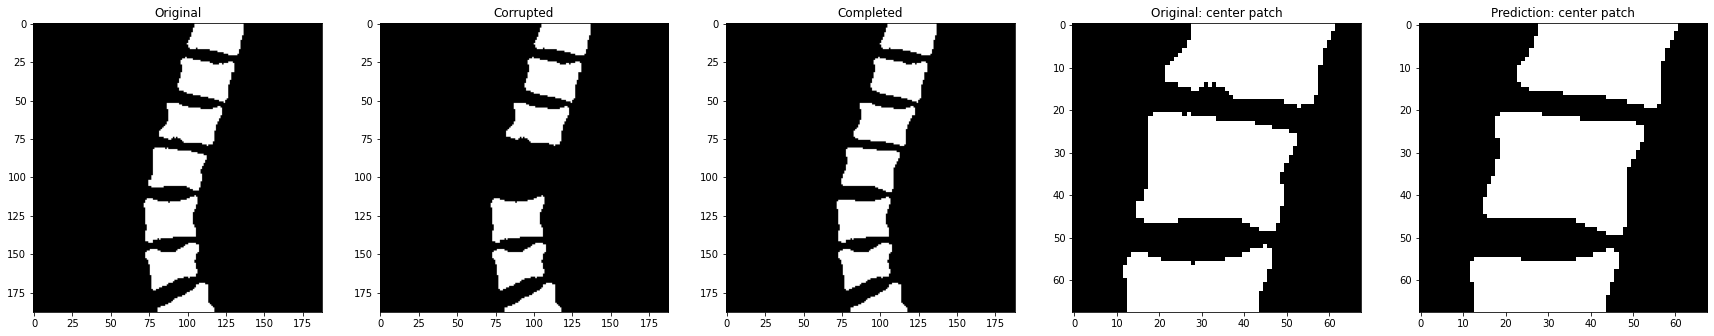

Loss: 0.07927664369344711


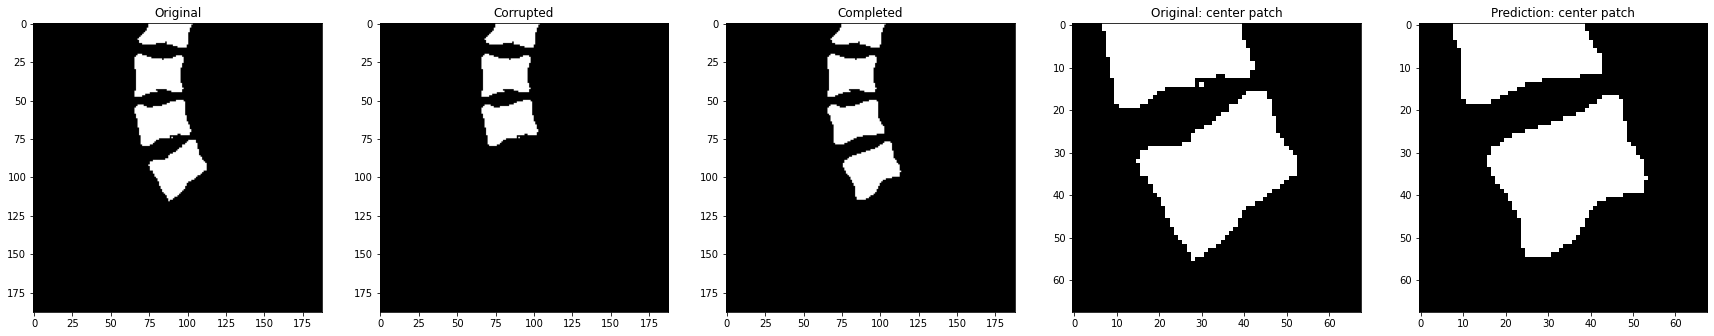

Loss: 0.06027023121714592


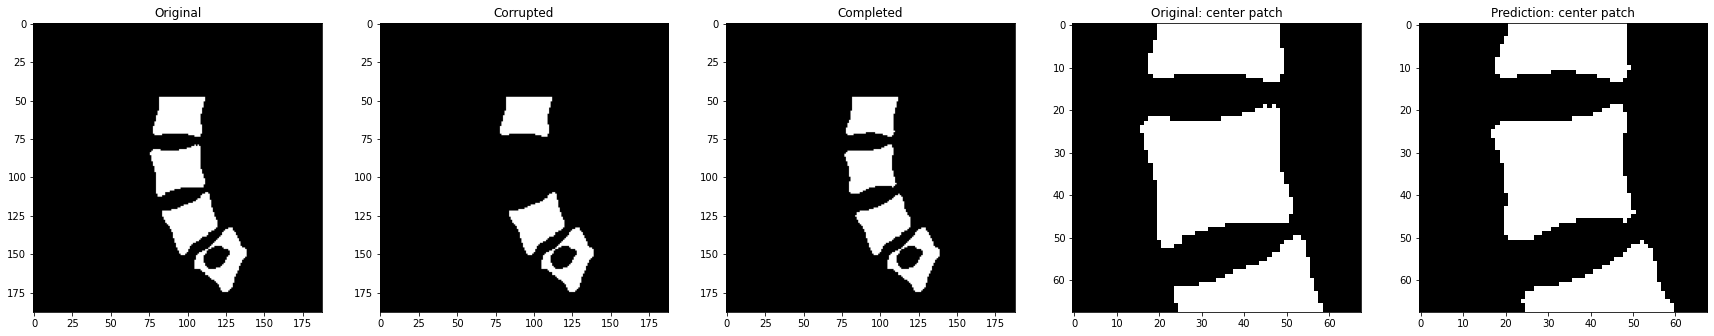

Loss: 0.20355473458766937


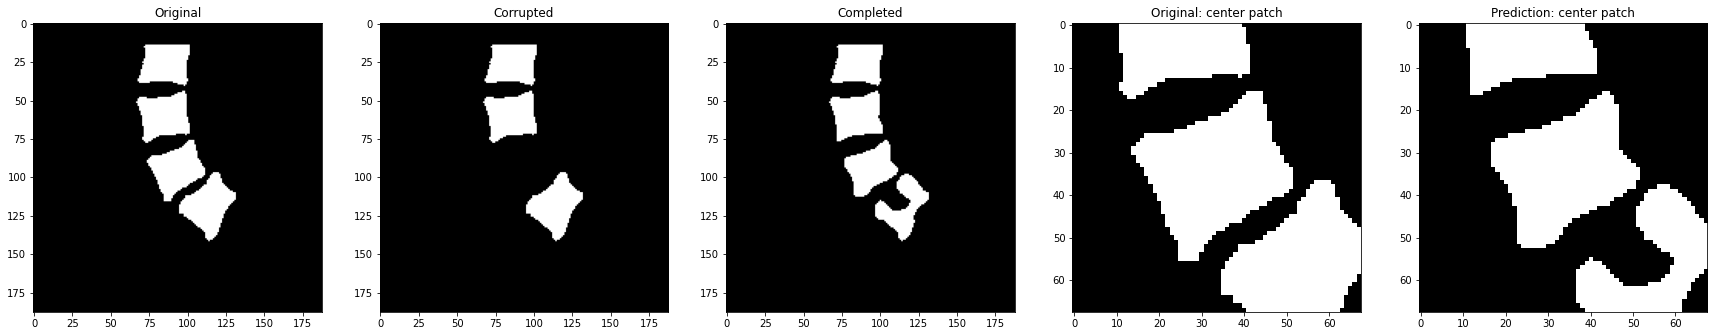

Loss: 0.10723494738340378


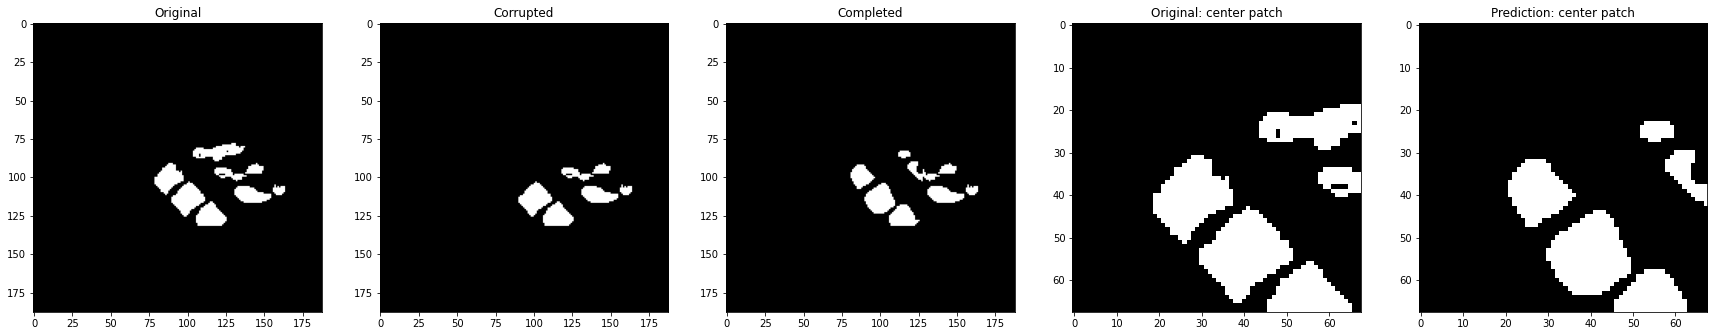

Loss: 0.10851480811834335


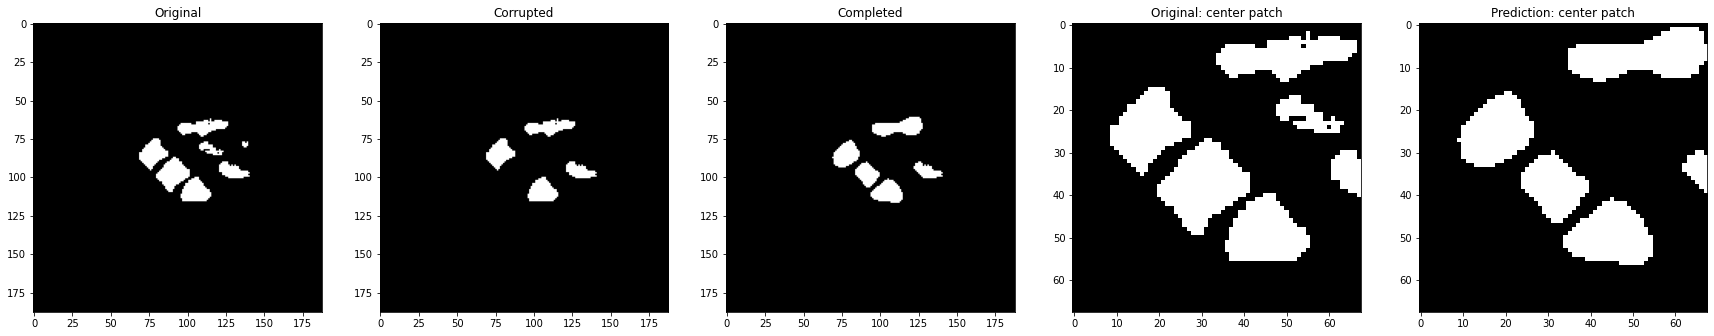

Loss: 0.0488421805202961


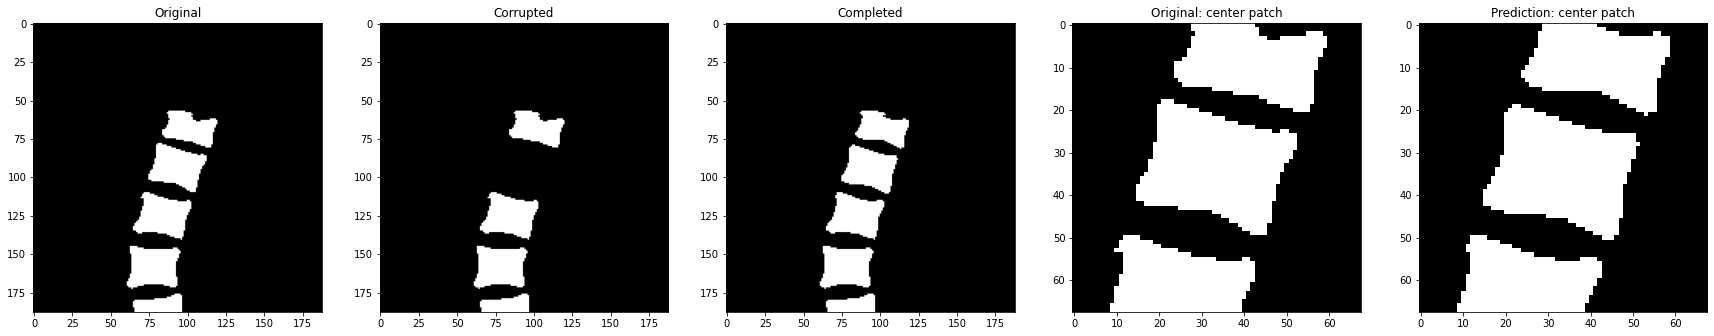

Loss: 0.04219882935285568


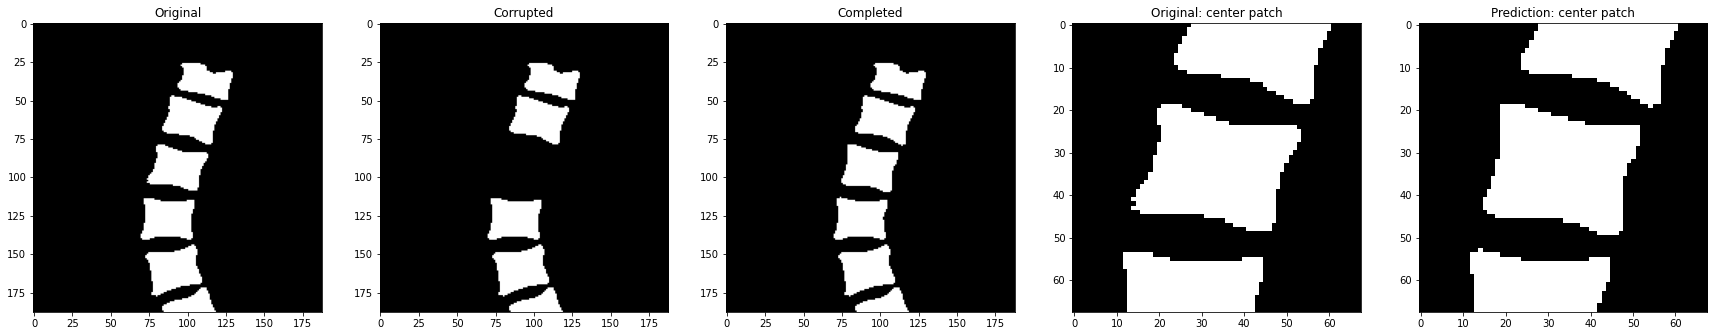

Loss: 0.055244073271751404


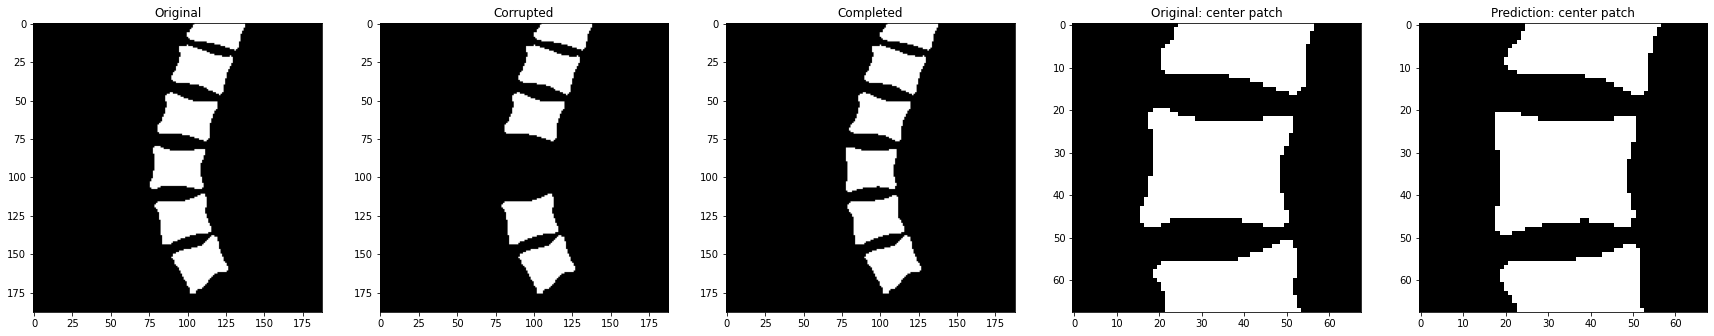

Loss: 0.08170264214277267


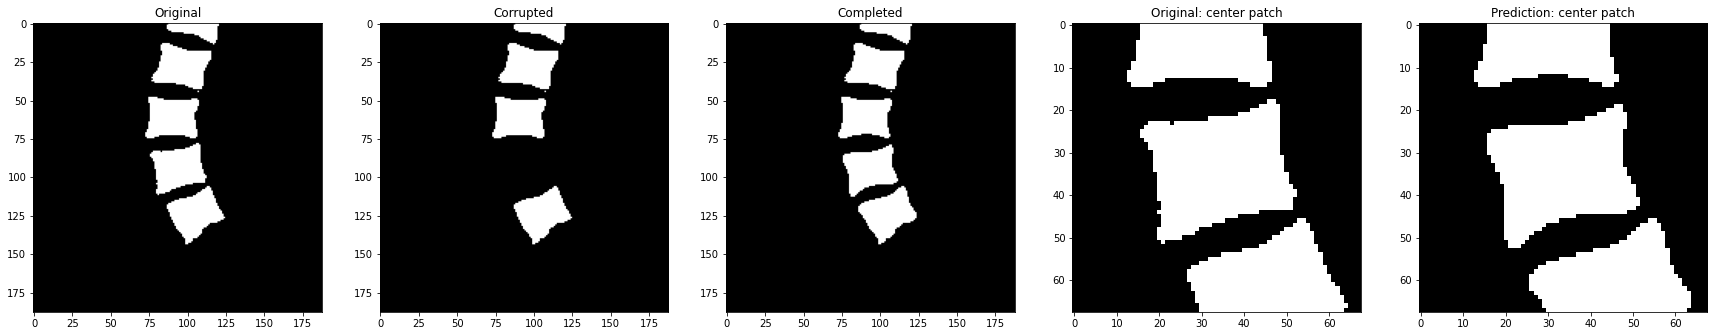

Loss: 0.06320091336965561


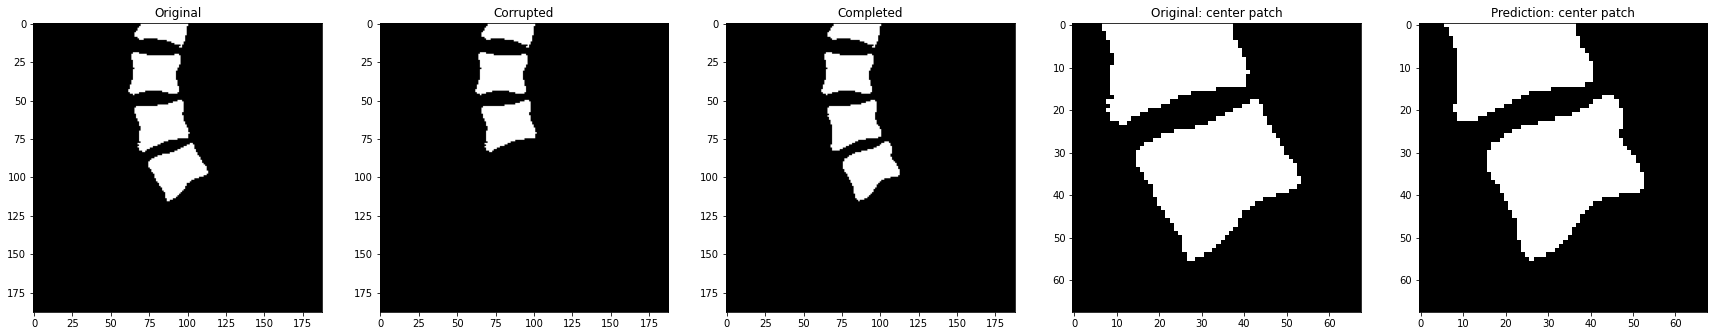

Loss: 0.025834299623966217


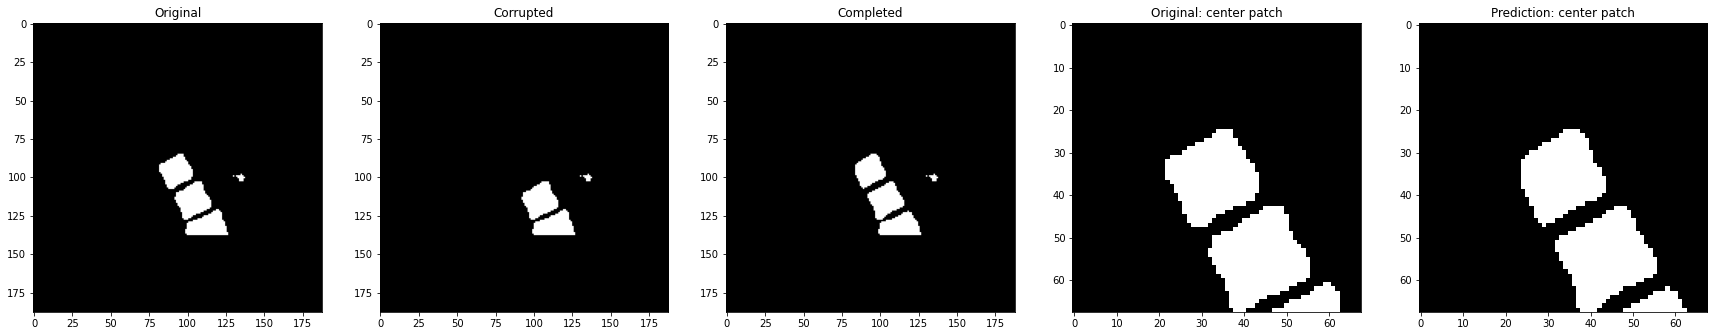

Loss: 0.0622163787484169


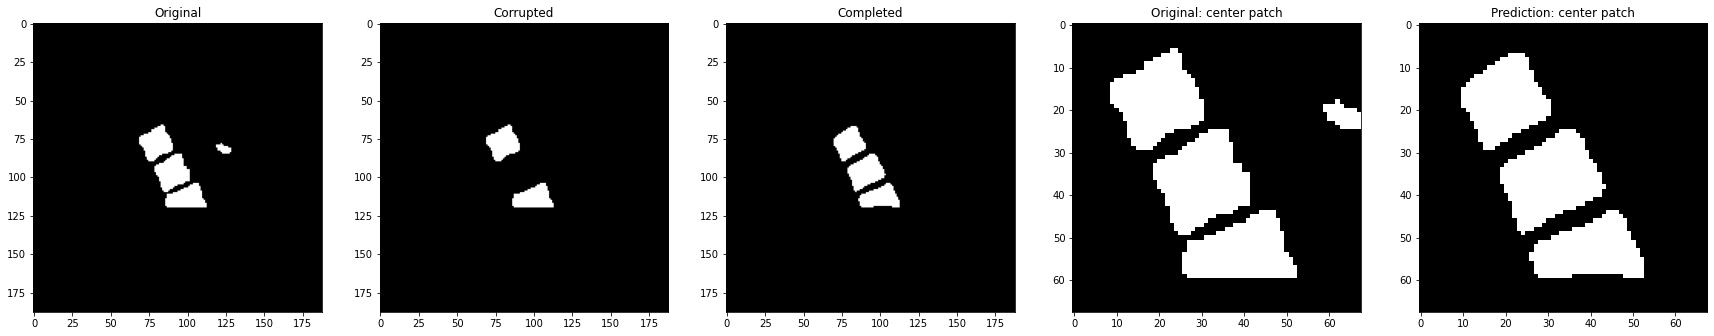

Loss: 0.035939257591962814


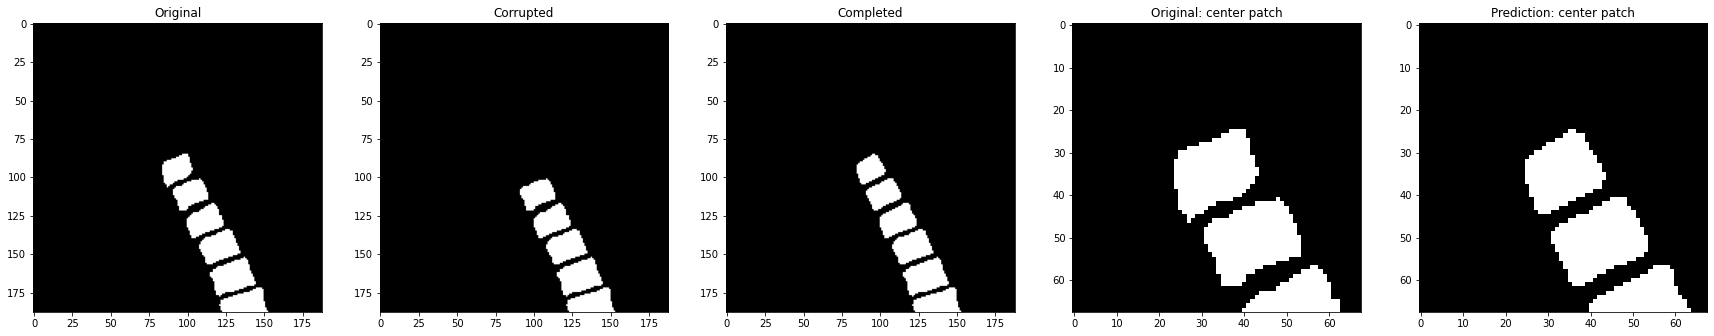

Loss: 0.039350662380456924


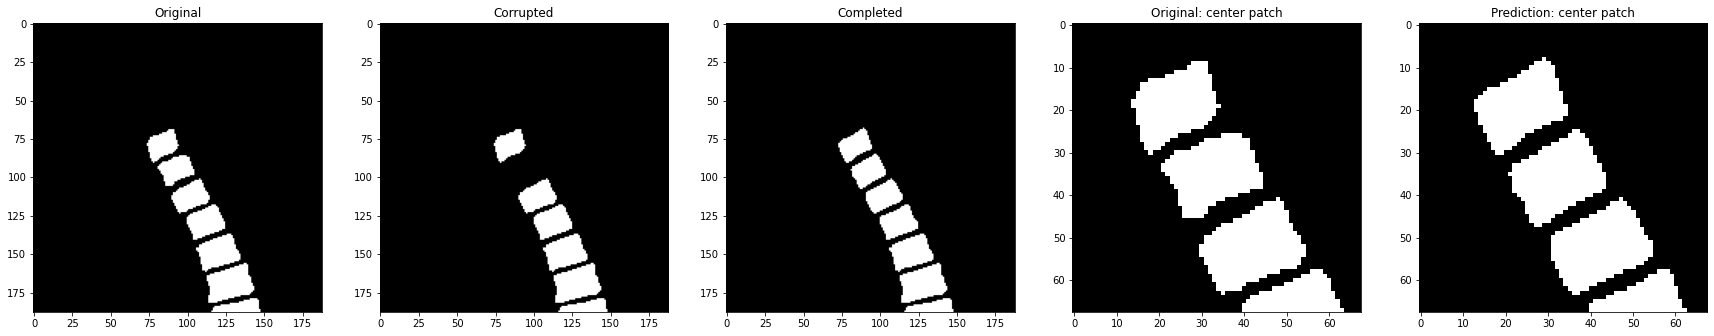

Loss: 0.042829789221286774


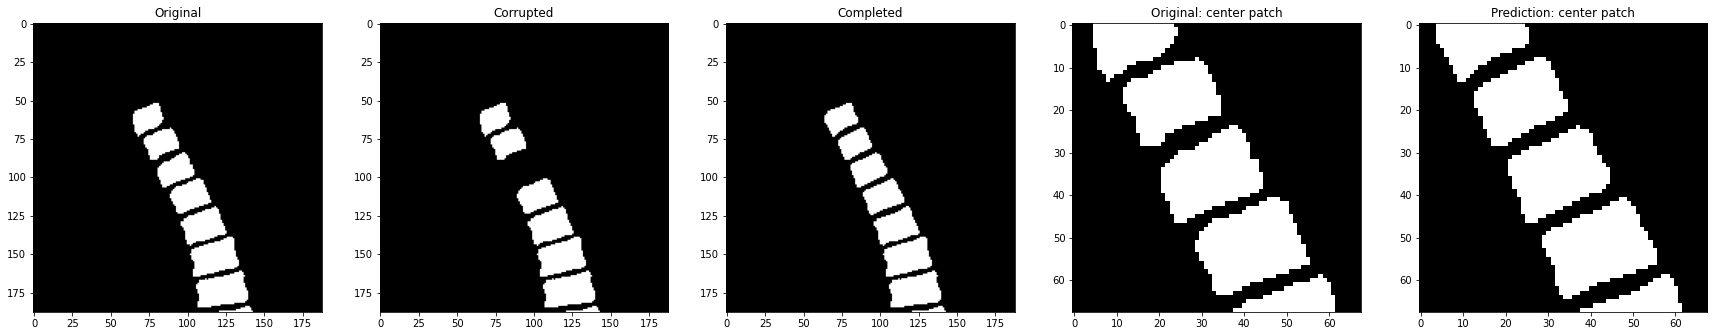

Loss: 0.03940726816654205


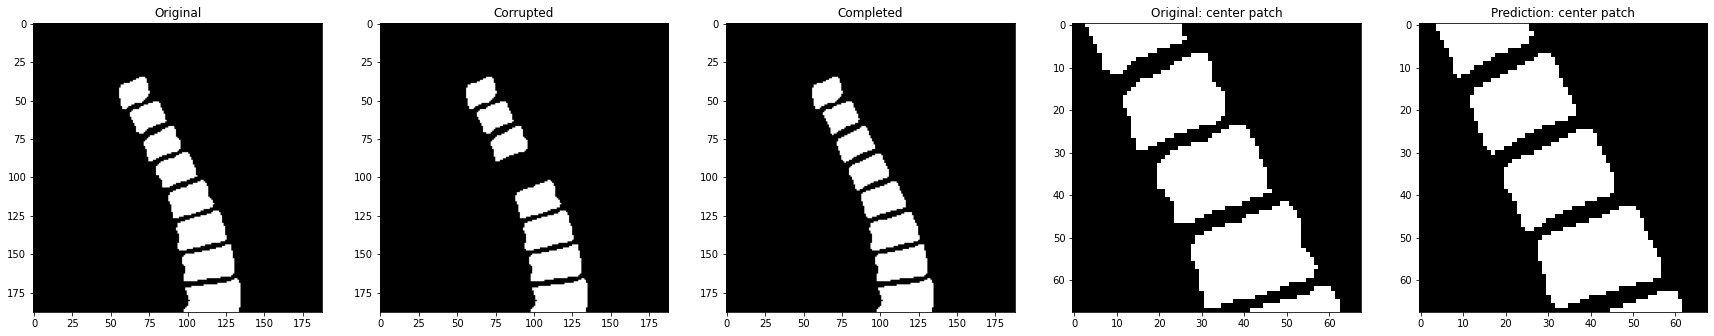

Loss: 0.03681037202477455


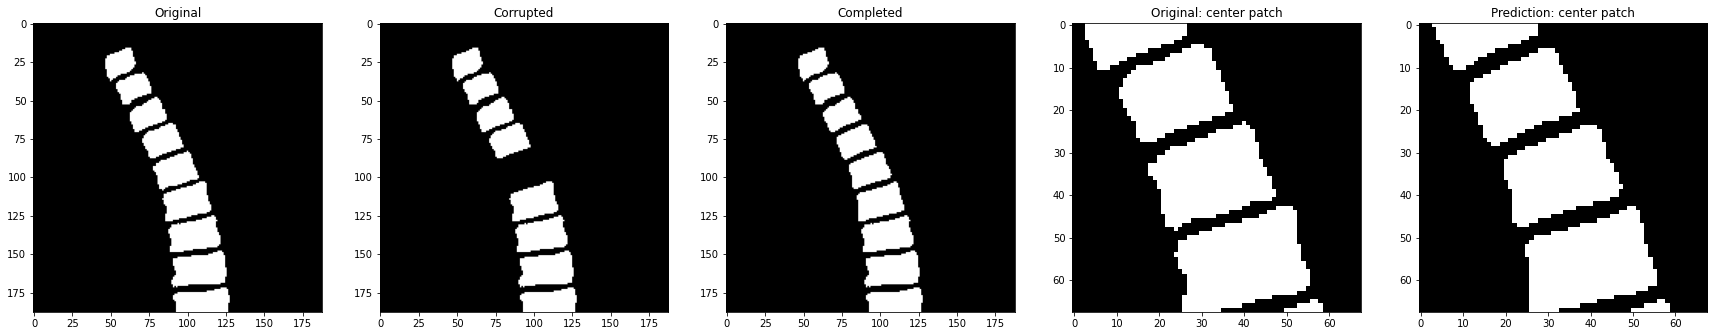

Loss: 0.0389203242957592


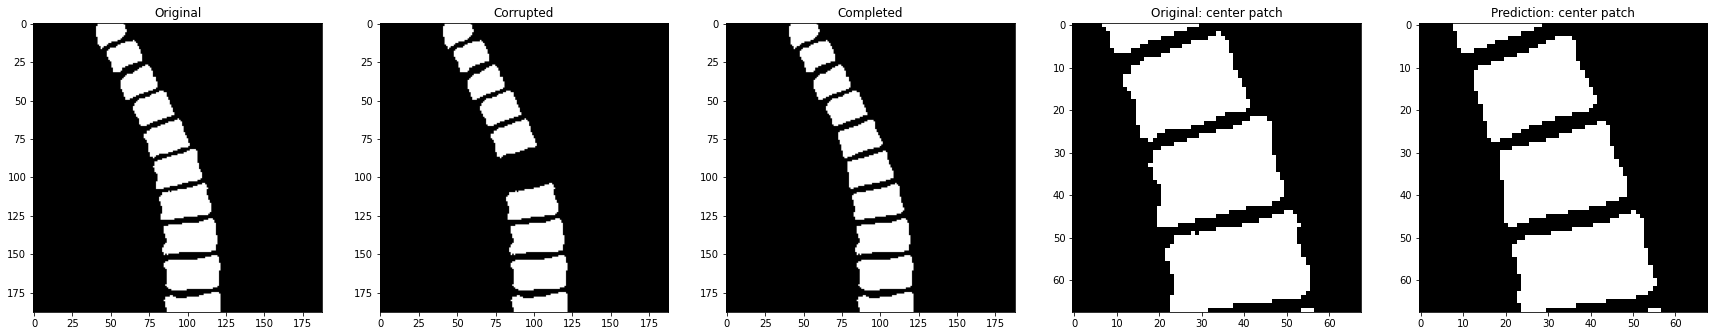

Loss: 0.03696727380156517


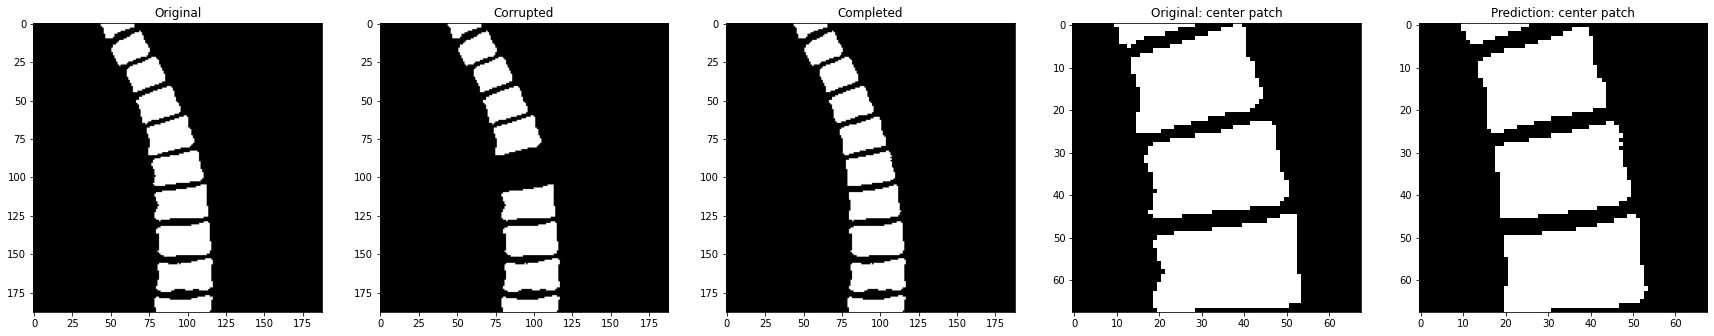

Loss: 0.03689806908369064


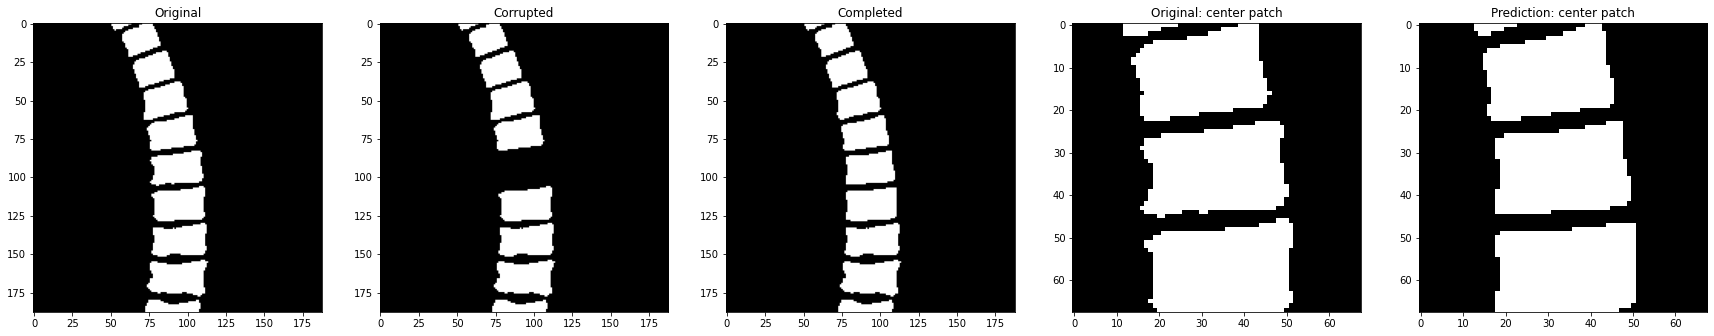

Loss: 0.04182998836040497


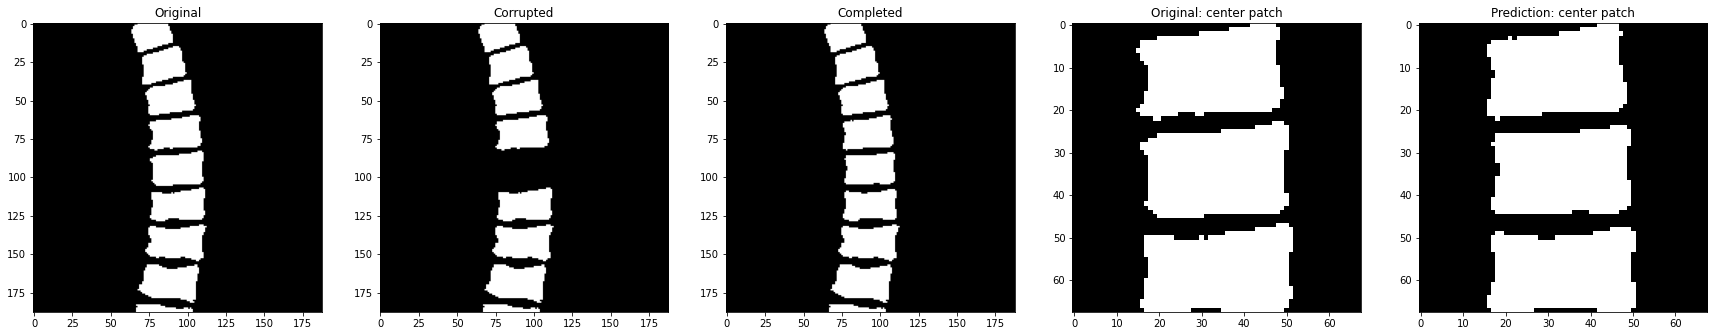

Loss: 0.05449690297245979


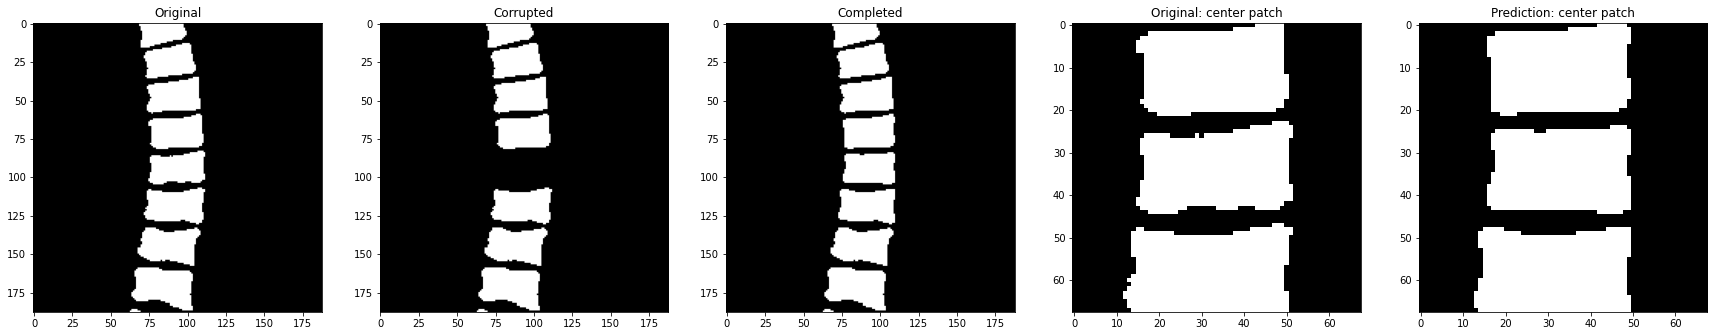

Loss: 0.06764315813779831


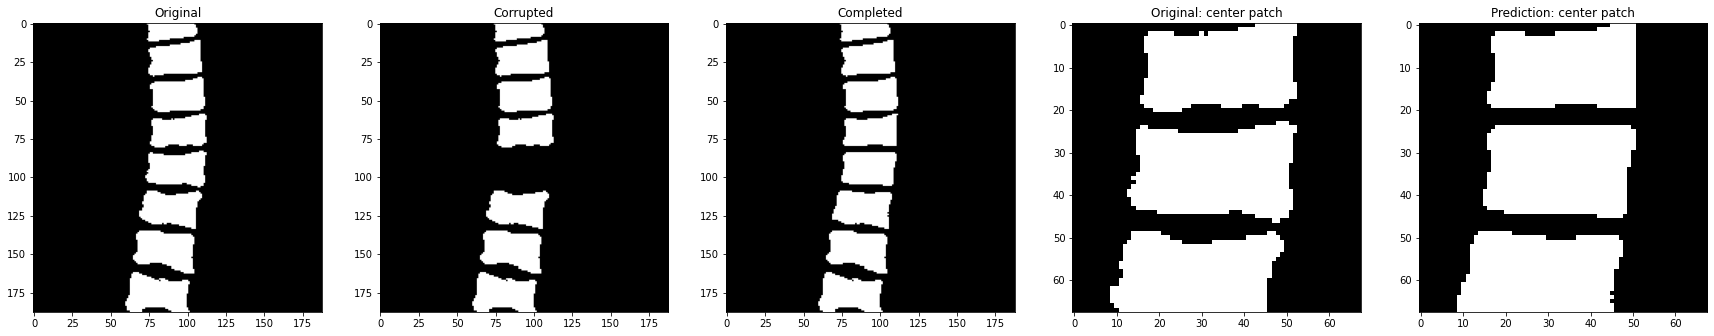

Loss: 0.05562814697623253


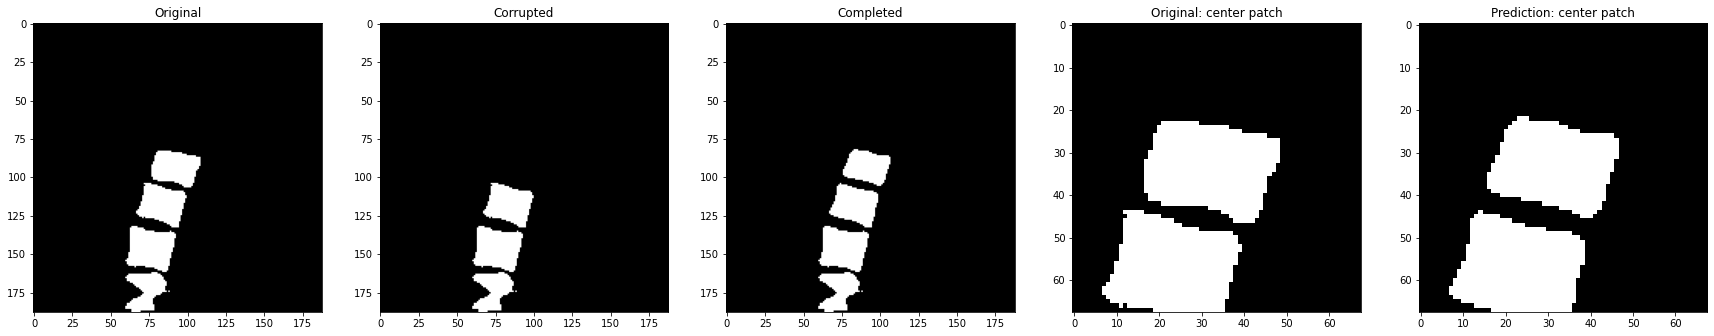

Loss: 0.053870003670454025


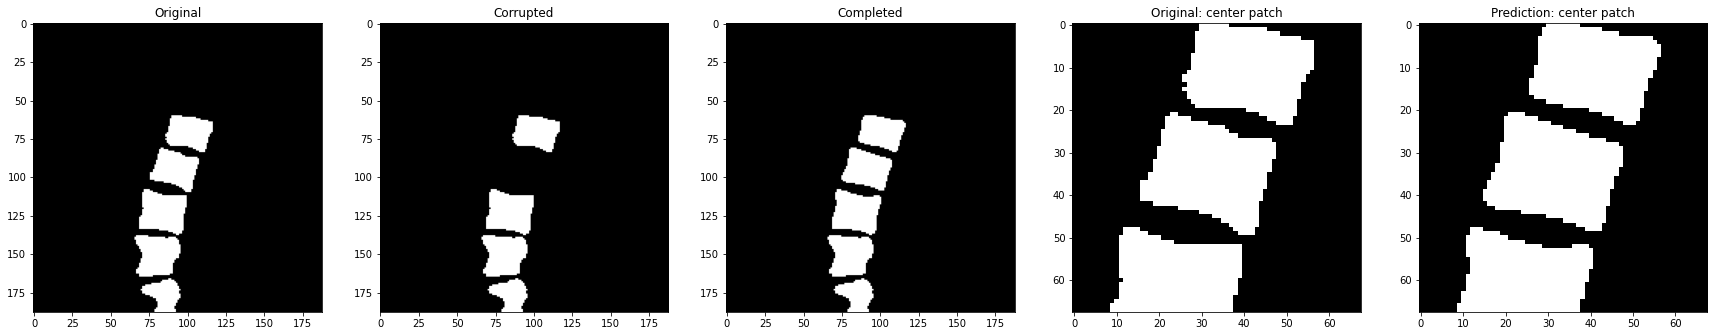

Loss: 0.05280349776148796


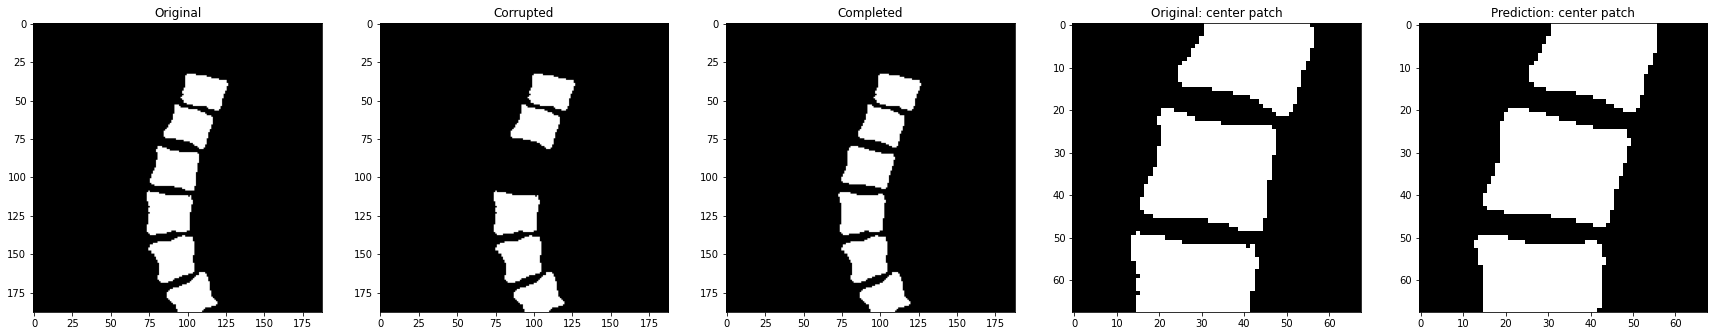

Loss: 0.04288731515407562


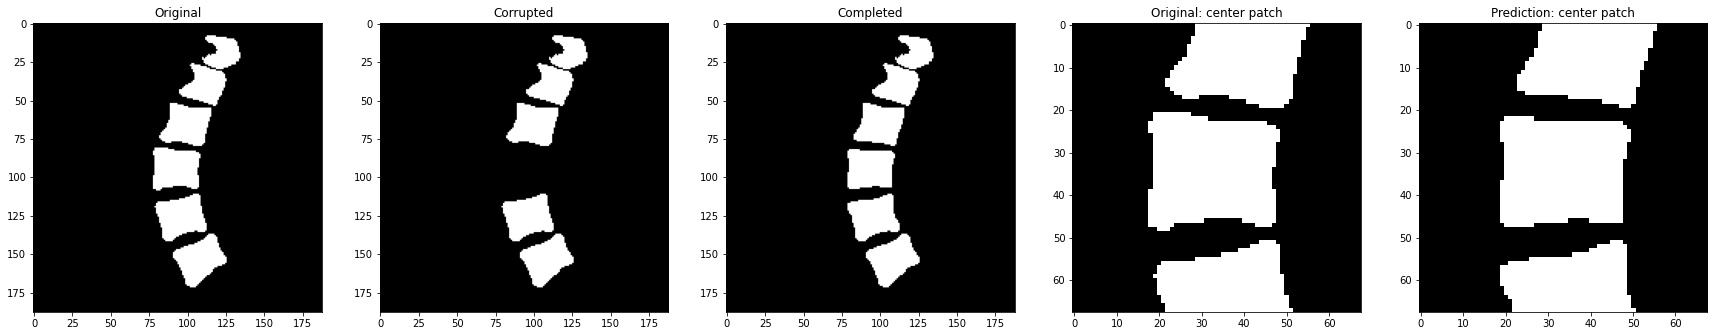

Loss: 0.04888257011771202


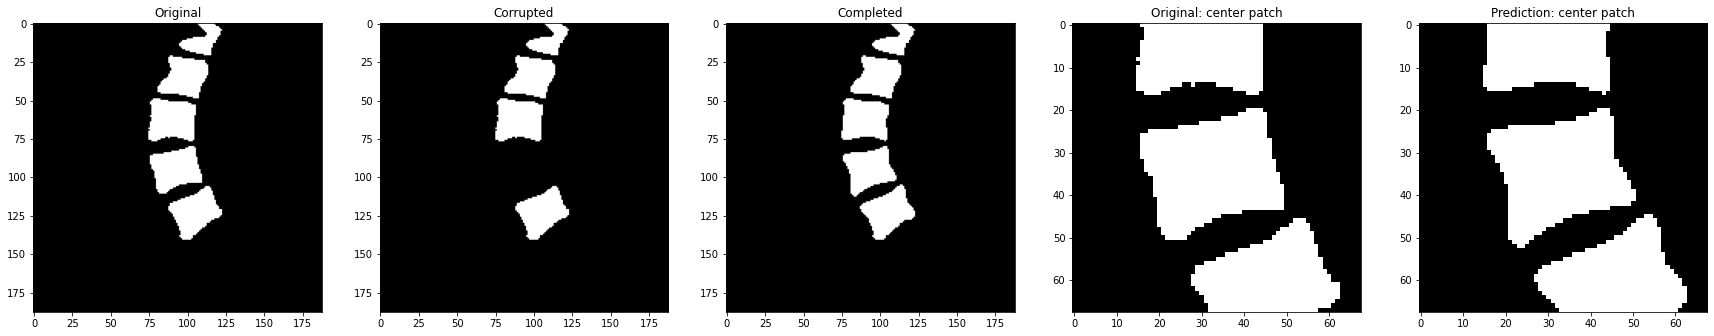

Loss: 0.07230822741985321


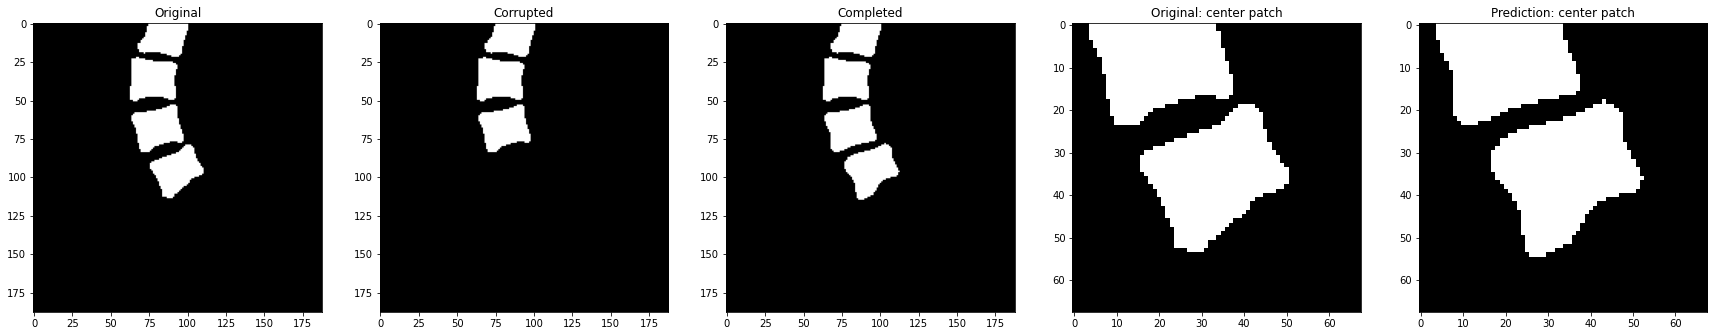

Loss: 0.04312997683882713


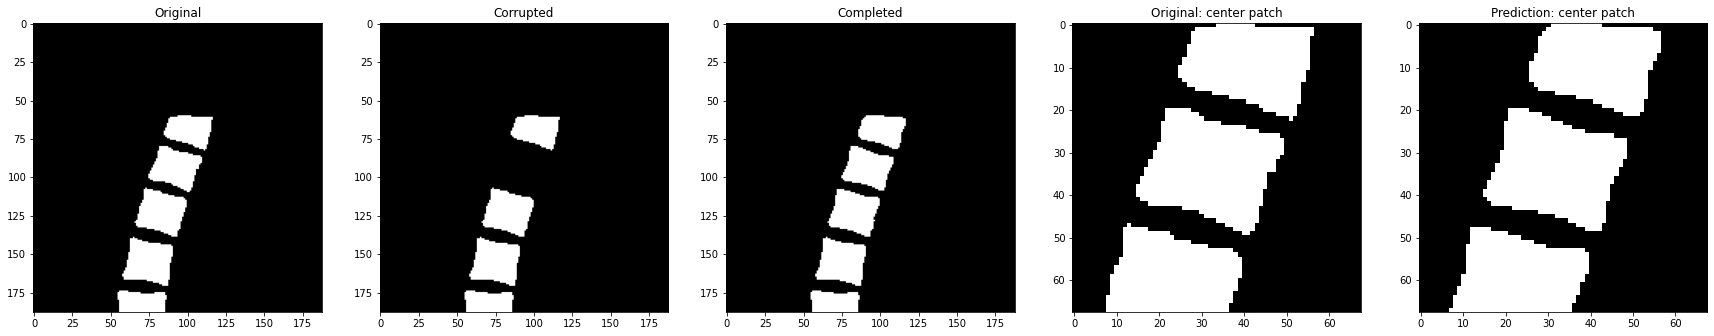

Loss: 0.036255963146686554


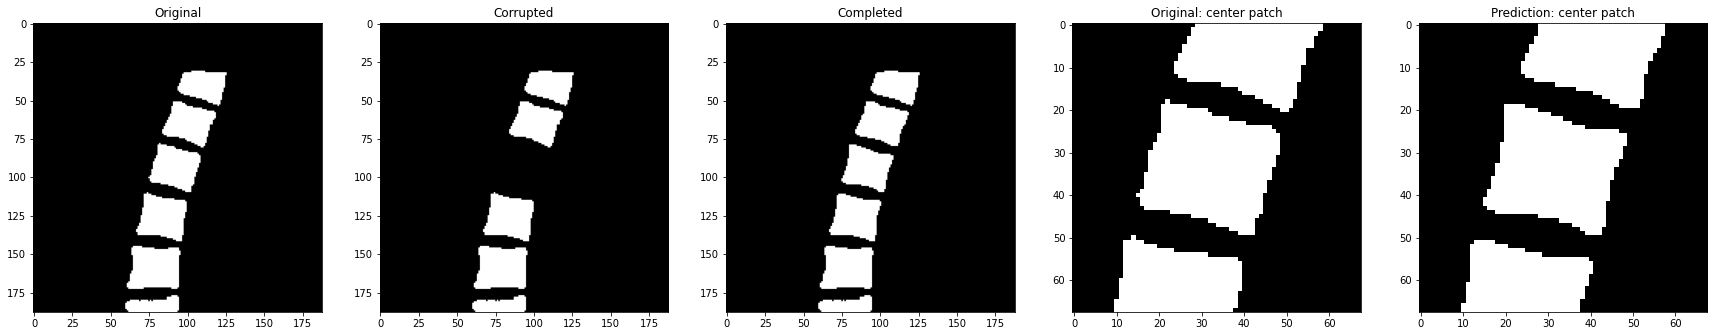

Loss: 0.032051388174295425


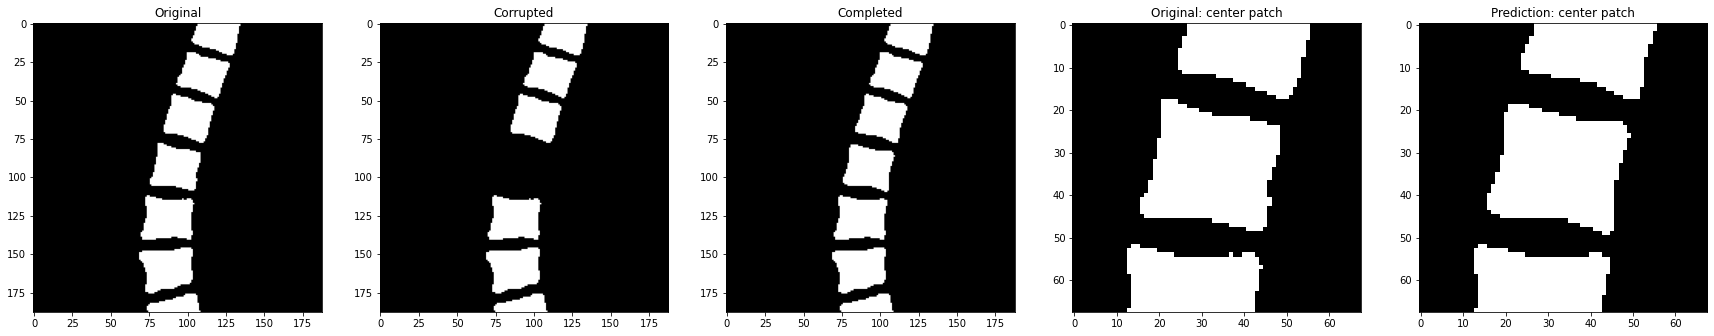

Loss: 0.03994398191571236


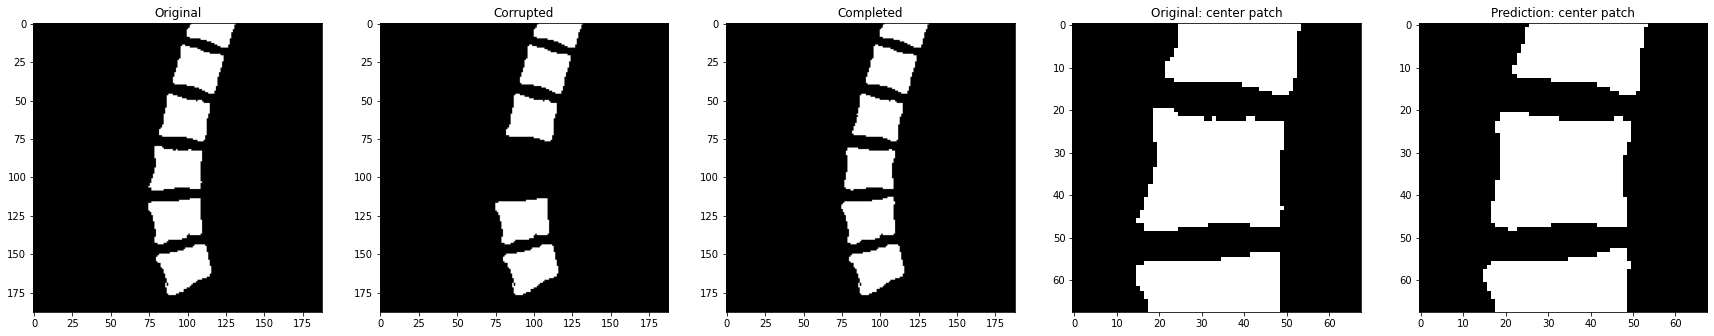

Loss: 0.06105202063918114


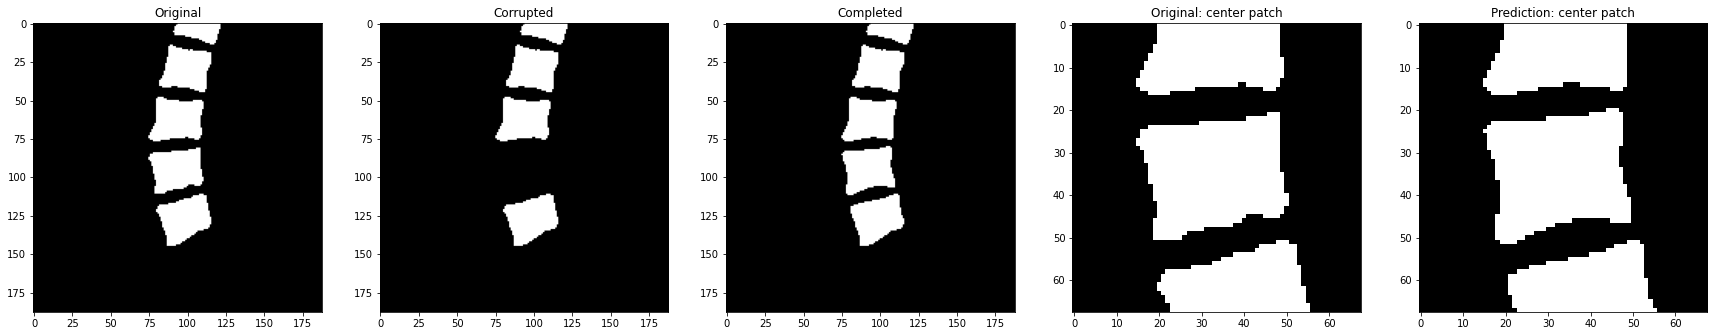

Loss: 0.06109696254134178


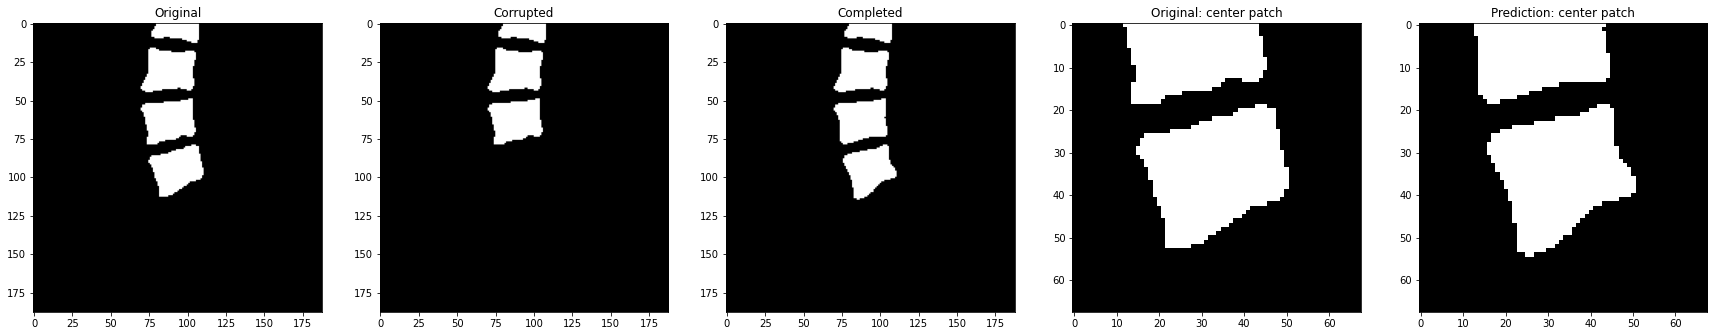

Loss: 0.026575593277812004


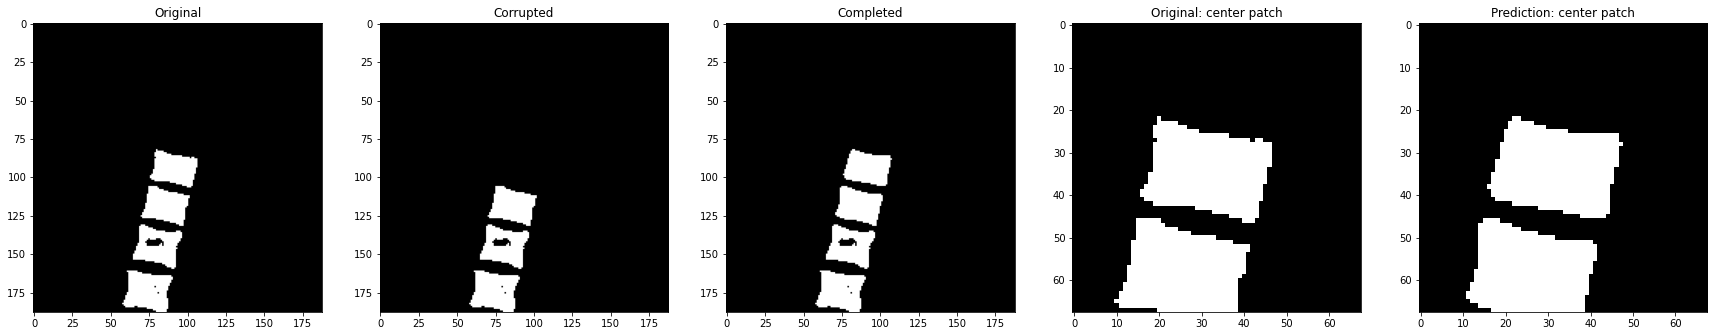

Loss: 0.06637732684612274


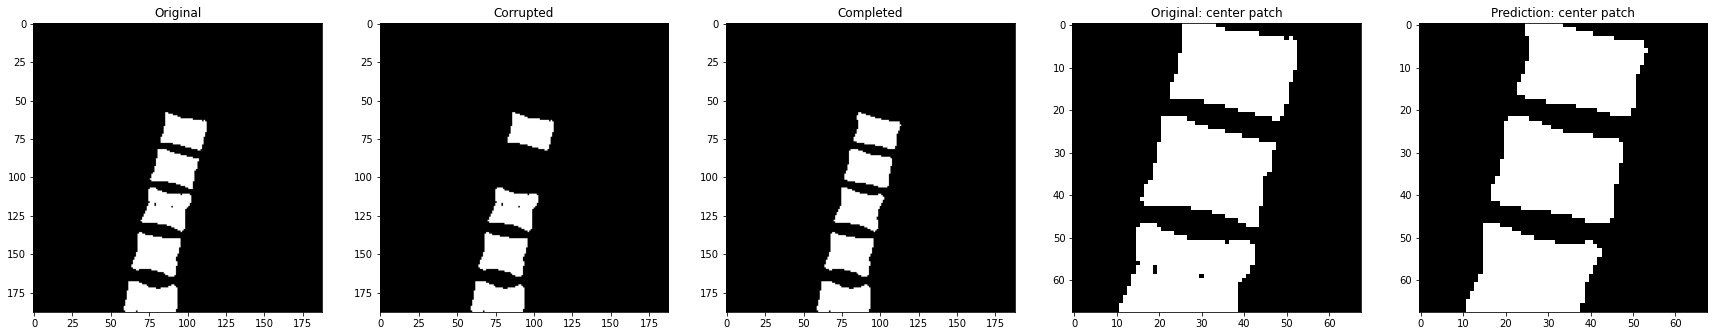

Loss: 0.09863980859518051


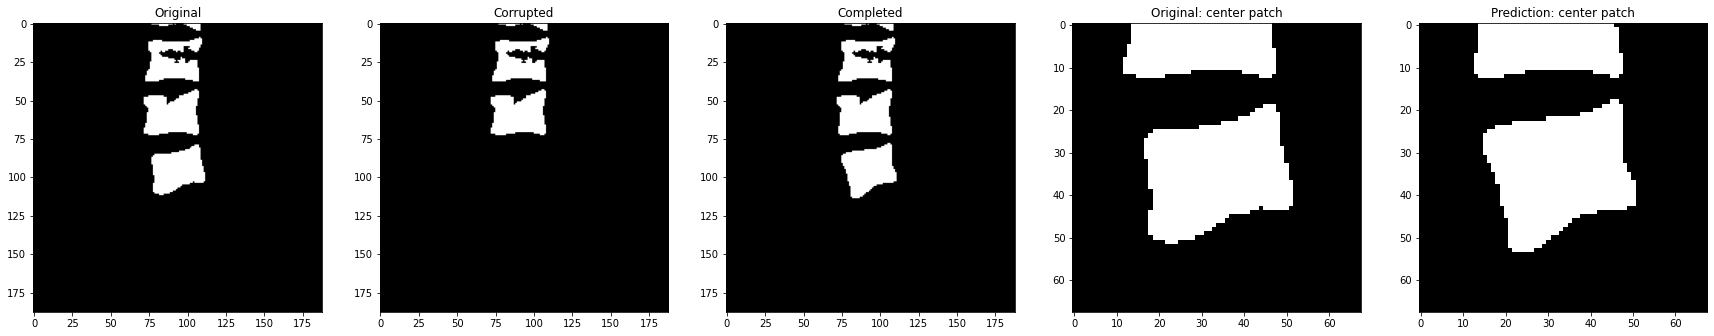

Loss: 0.03208720684051514


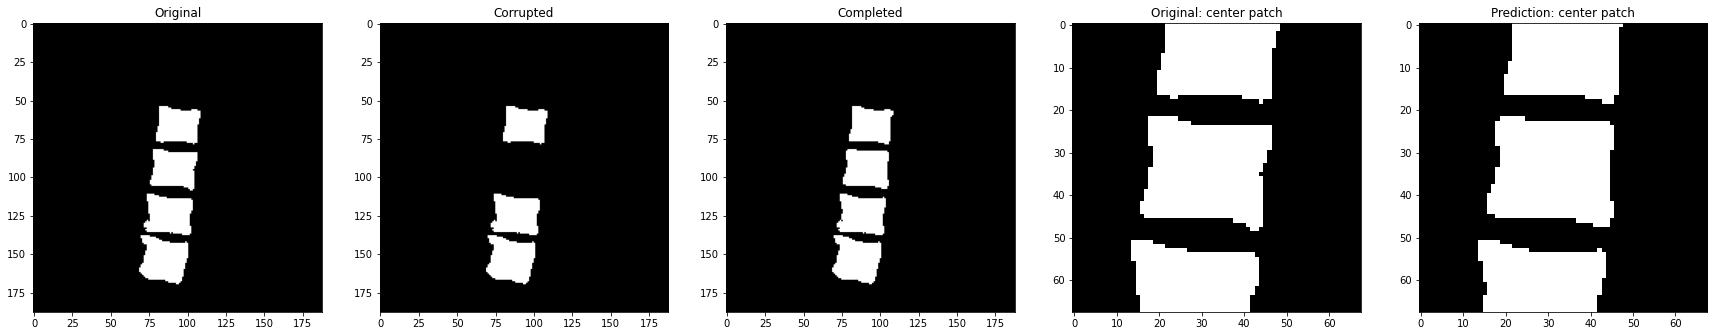

Loss: 0.05294540151953697


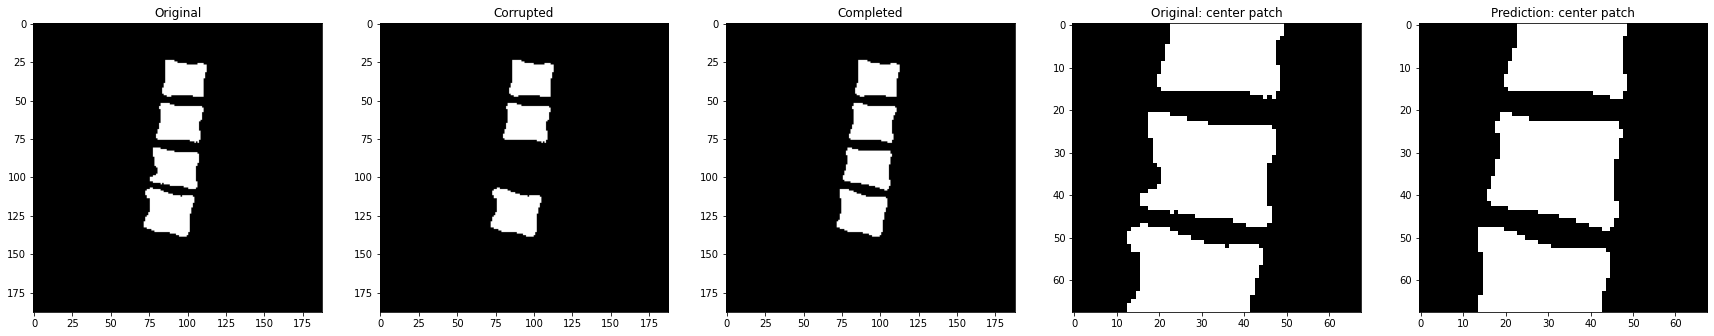

Loss: 0.1254892498254776


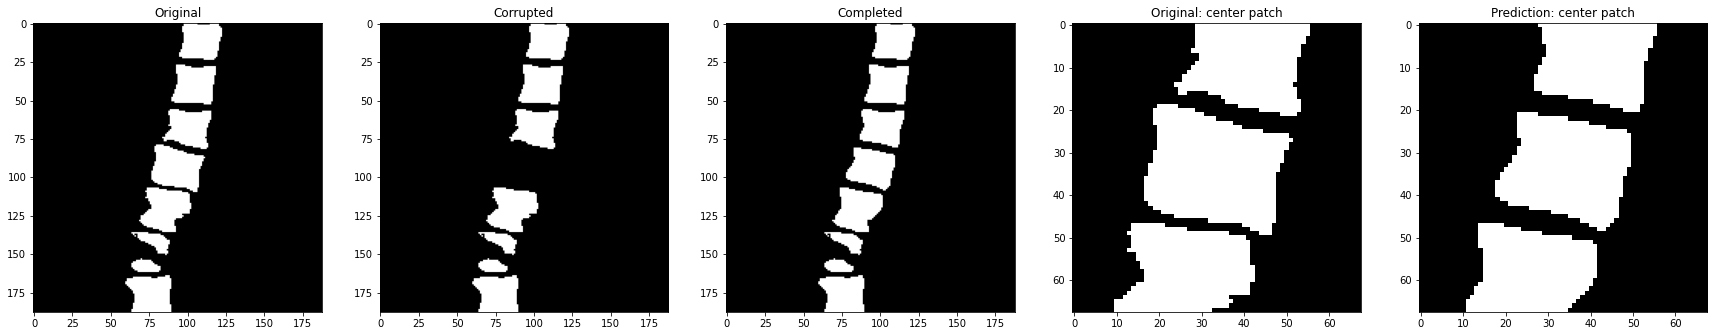

Loss: 0.1355312466621399


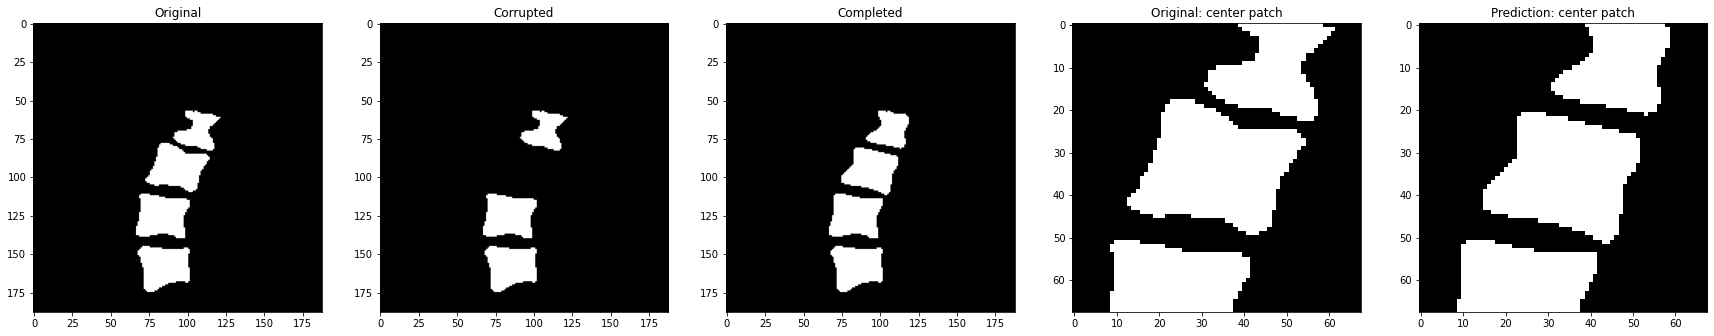

Loss: 0.07856034487485886


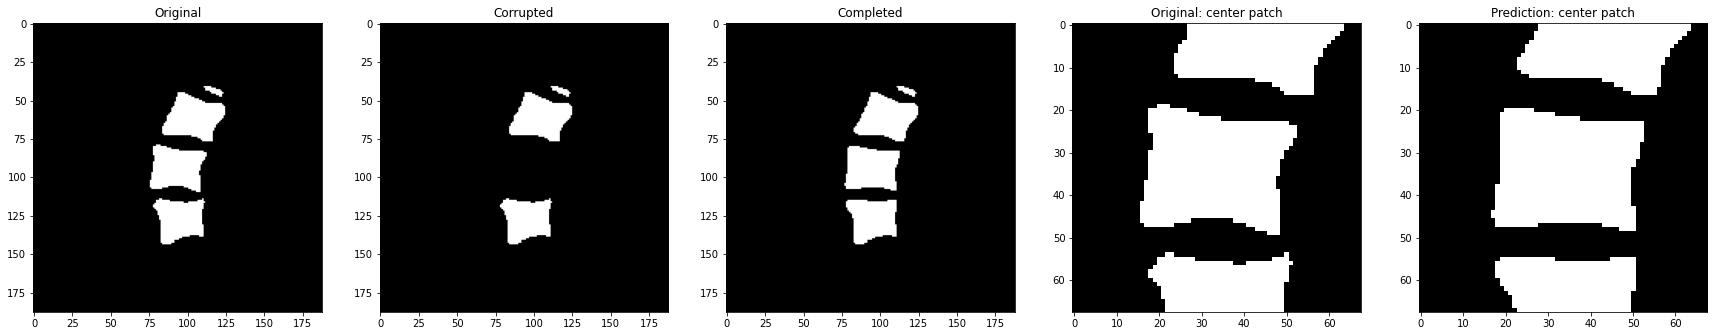

Loss: 0.17644475400447845


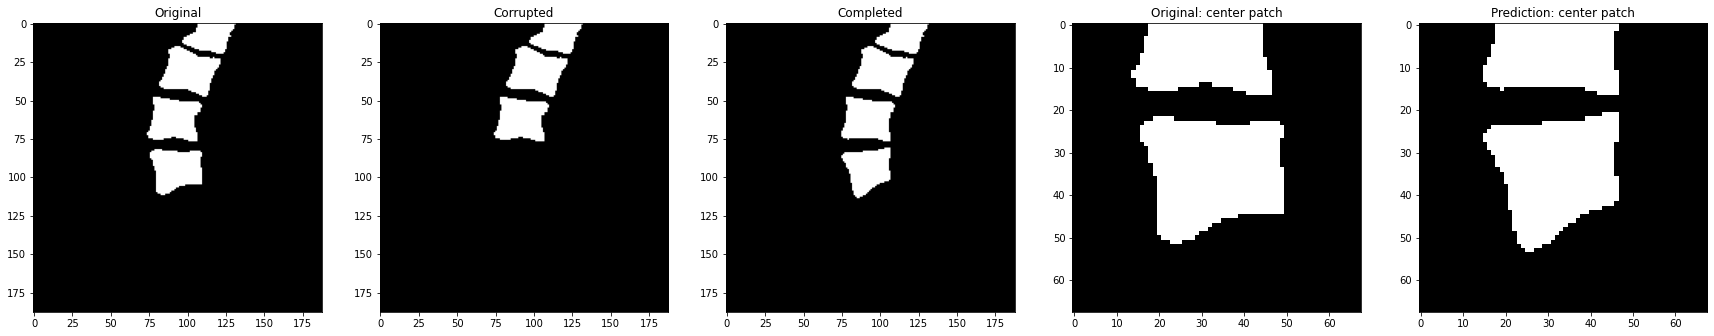

Loss: 0.016741806641221046


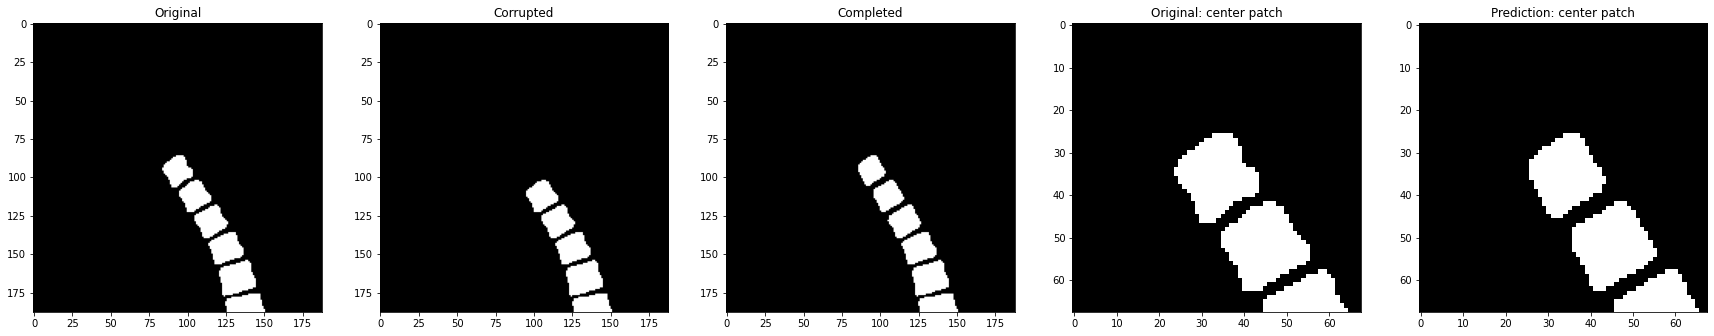

Loss: 0.02294672094285488


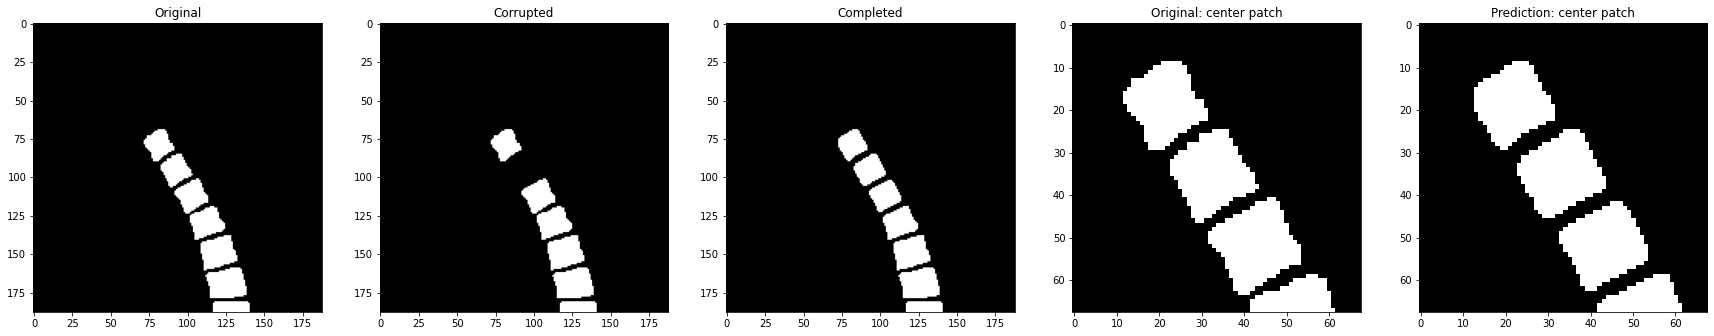

Loss: 0.02799084410071373


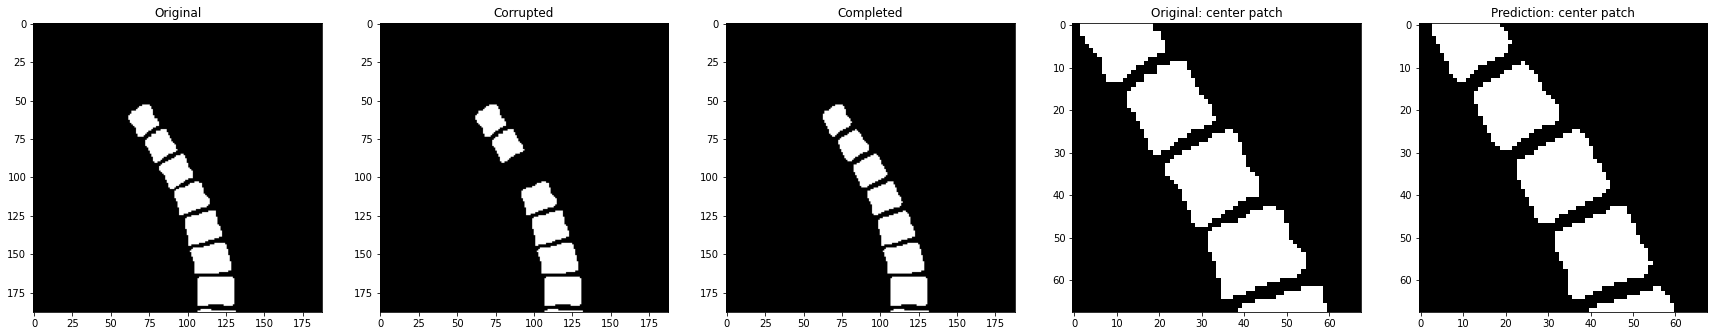

Loss: 0.026533260941505432


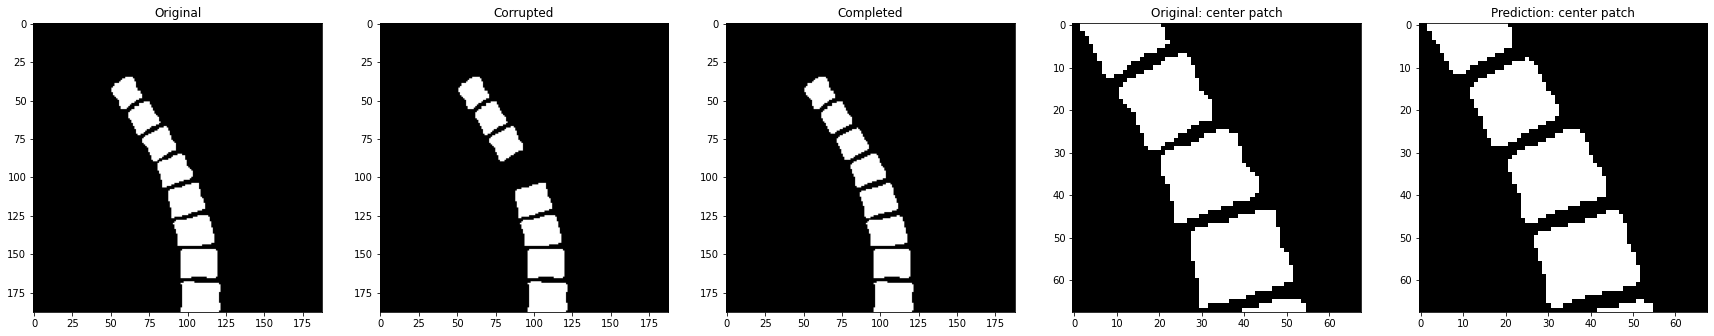

Loss: 0.02923833765089512


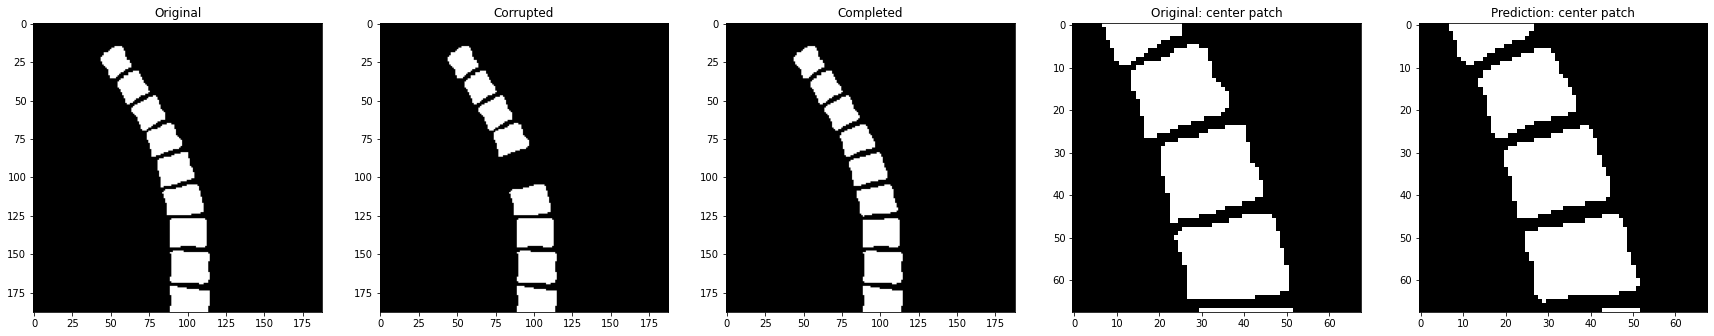

Loss: 0.028233051300048828


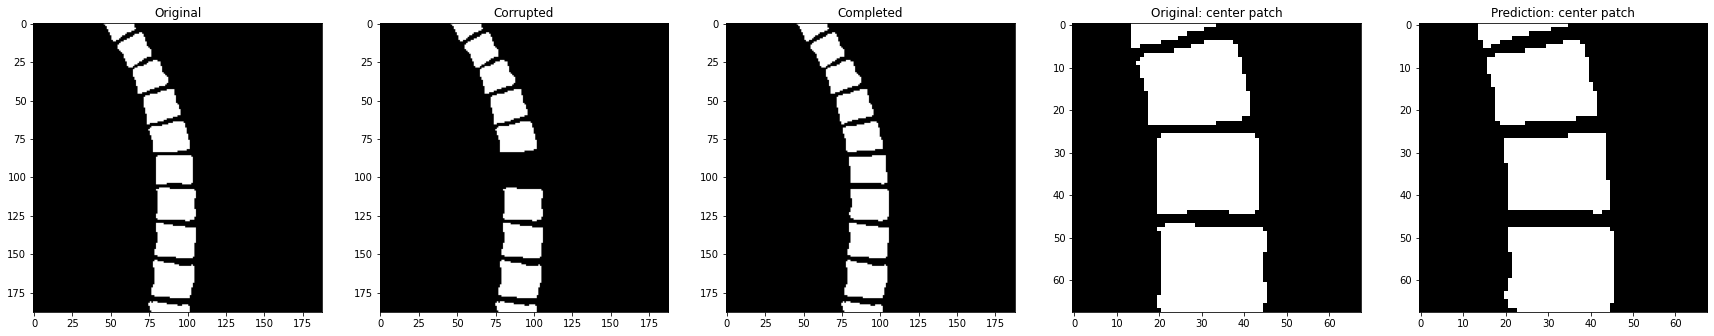

Loss: 0.027193306013941765


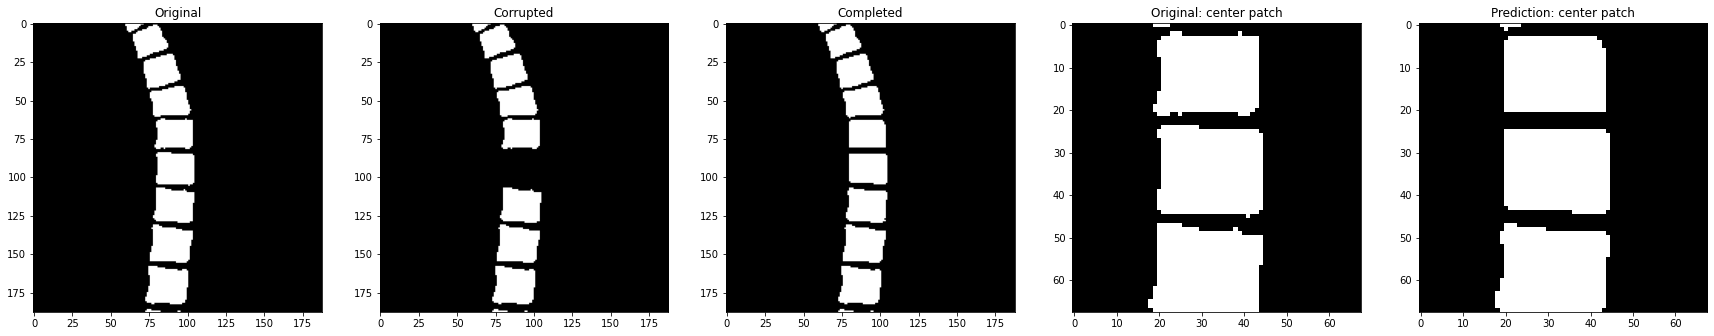

Loss: 0.028103720396757126


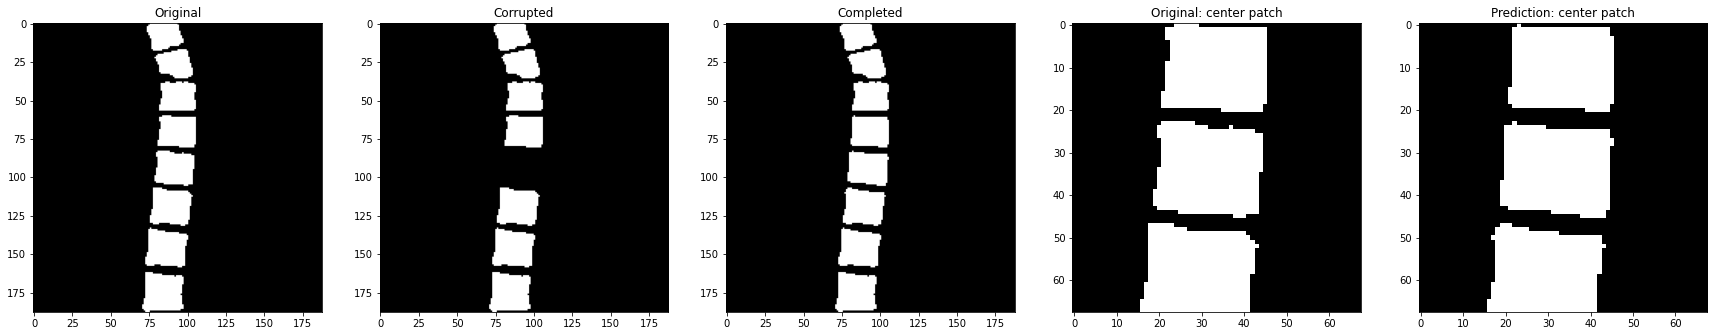

Loss: 0.0261442381888628


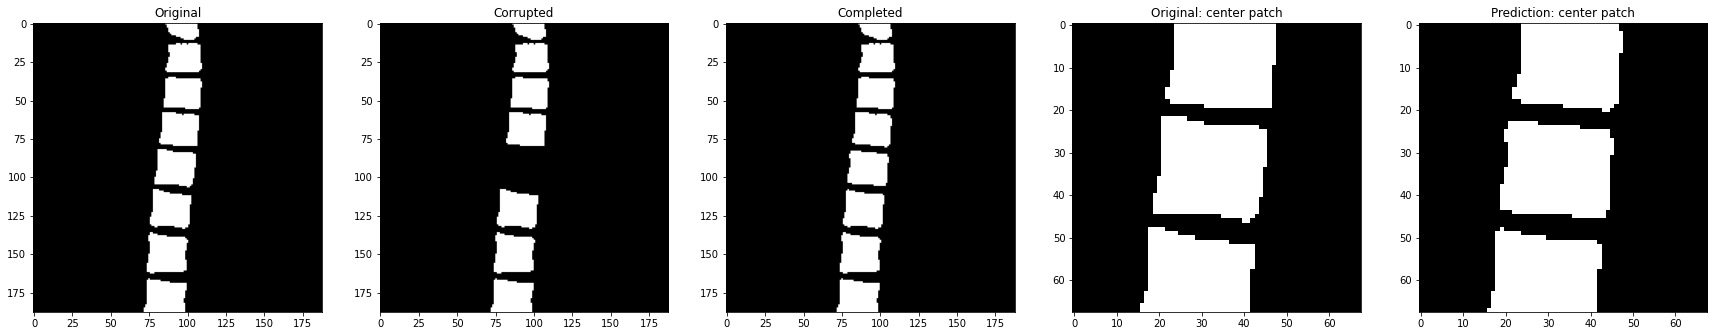

Loss: 0.025965914130210876


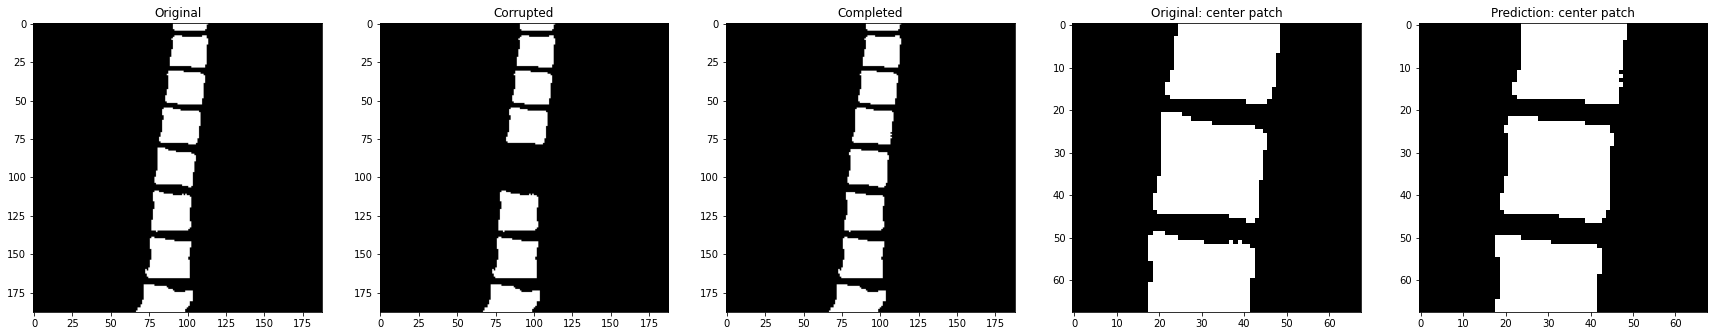

Loss: 0.03278210386633873


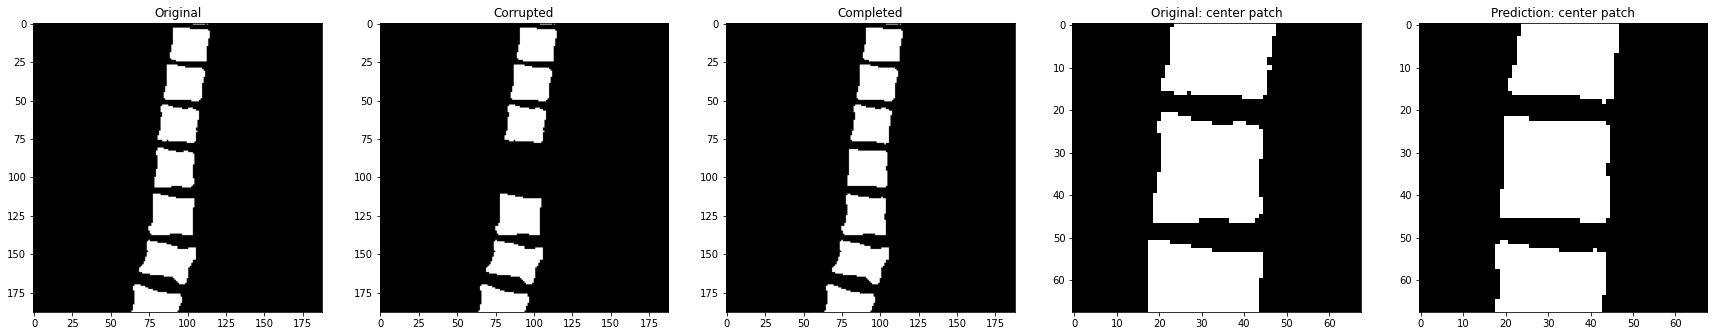

Loss: 0.041926831007003784


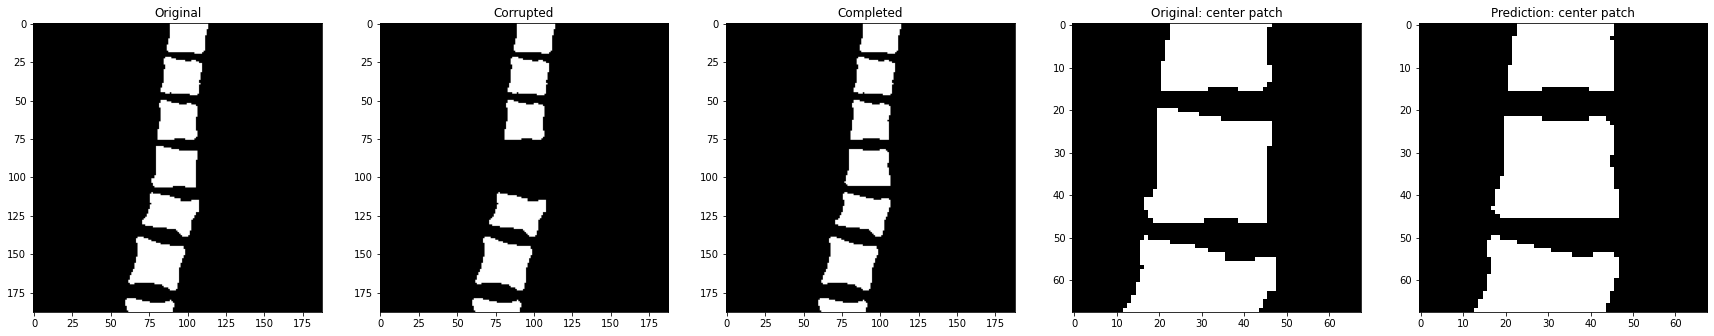

Loss: 0.04932127147912979


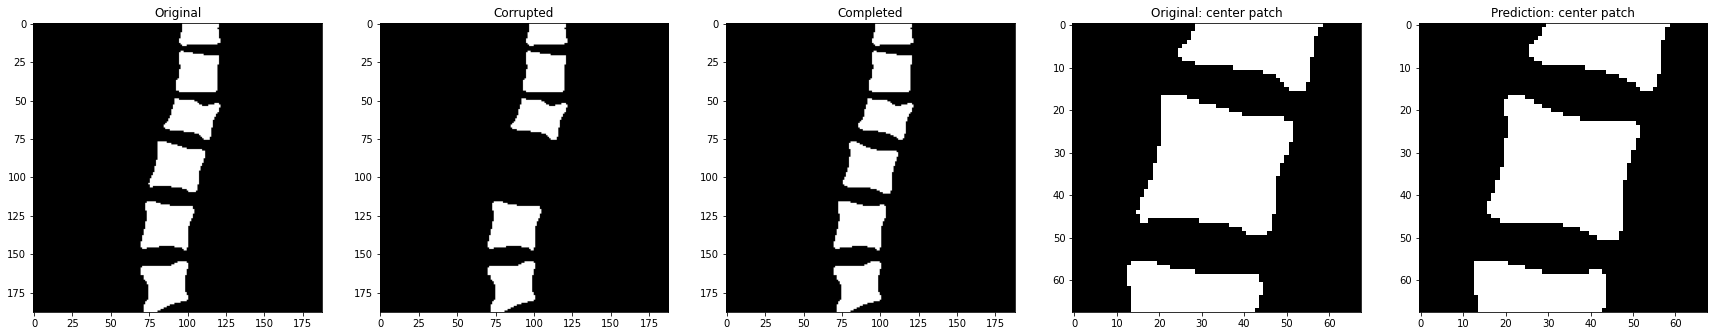

Loss: 0.052919816225767136


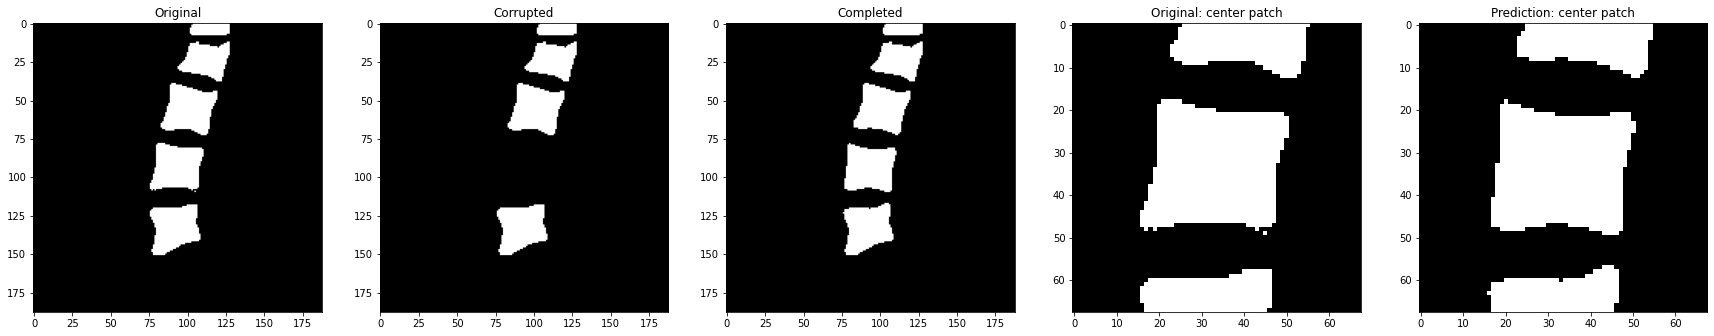

Loss: 0.04929966479539871


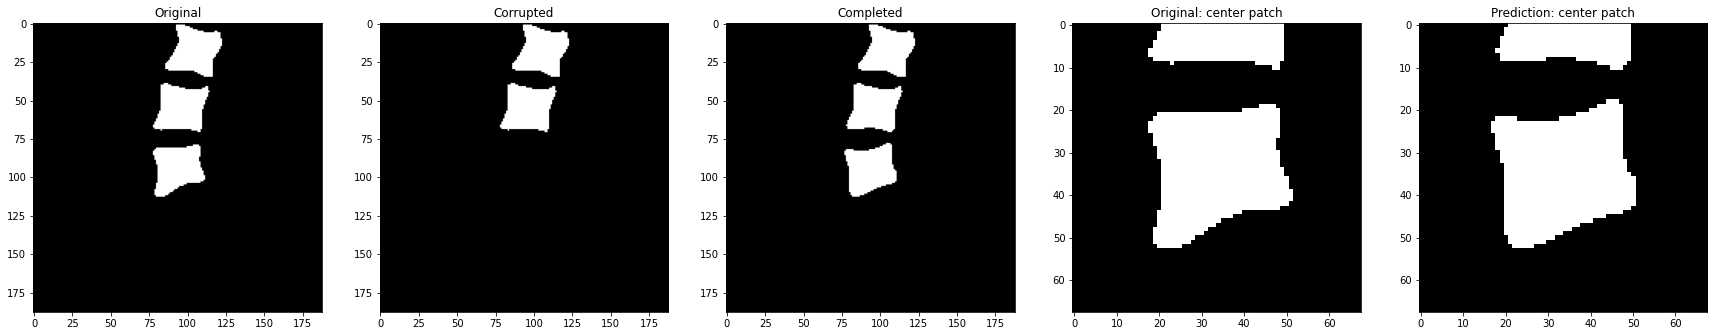

In [28]:
loss_sum = 0.0

for m, z in test_loader:      # m is complete mask, z is incomplete mask

    # forward batch
    m_pred = model.forward(z.to(device))

    # extract middle, for which a prediction is made, from the complete mask
    start = (patch_size[-1] - m_pred.shape[-1]) // 2
    end = start + m_pred.shape[-1]
    m_true = m[:, :, start:end, start:end, start:end].to(device)

    # compute loss & print loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(m_pred, m_true)
    loss_sum += loss.item()
    print('Loss: {}'.format(loss))   
    
    # compute hard predictions and plot mid slice
    m_hard = m_pred.cpu().detach() > 0
    
     # fill in in the corrupted mask
    z_completed = z.detach().clone()
    z_completed[:, :, start:end, start:end, start:end] = m_hard

    plt.figure(figsize=(30, 20))
    plt.subplot(151)
    plt.gca().set_title('Original')
    plt.imshow(m[0, 0, 94, :, :].cpu().detach(), cmap='gray')
    plt.subplot(152)
    plt.gca().set_title('Corrupted')
    plt.imshow(z[0, 0, 94, :, :].cpu().detach(), cmap='gray')
    plt.subplot(153)
    plt.gca().set_title('Completed')
    plt.imshow(z_completed[0, 0, 94, :, :].cpu().detach(), cmap='gray')
    plt.subplot(154)
    plt.gca().set_title('Original: center patch')
    plt.imshow(m_true[0, 0, 34, :, :].cpu().detach(), cmap='gray')
    plt.subplot(155)
    plt.gca().set_title('Prediction: center patch')
    plt.imshow(m_hard[0, 0, 34, :, :].cpu().detach(), cmap='gray')
    plt.show()

In [29]:
print(loss_sum / len(test_loader))

0.051996210031211375
